In [1]:
const SAVED_DIR = "/Volumes/Samsung250GB/temperature_model/saved"

"/Volumes/Samsung250GB/temperature_model/saved"

In [2]:
data_dir="../"

"../"

In [3]:
using DataFrames
using Base.Dates

In [4]:
import PyPlot; plt=PyPlot
using LaTeXStrings
plt.rc("figure", dpi=300.0)
plt.rc("figure", figsize=(8,5))
plt.rc("savefig", dpi=400.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

In [5]:
iowa_time(ts) = ts - Hour(6)
ilocaltime = circshift(1:24, -6)
;

In [6]:
include("../src/TempModel.jl")

TempModel

In [7]:
# obtain the list of stations
isdList=TempModel.read_isdList(;data_dir=data_dir)
# just the Iowa stations
isdSubset=isdList[[(usaf in (725450,725460,725480,725485)) for usaf in isdList[:USAF]],:]

# obtain the hourly temperature measurements for those stations
hourly_cat=TempModel.read_Stations(isdSubset; data_dir=data_dir)
# mark station 3 (Waterloo) as the test station
itest=3
# separate temperatures into train and test
hourly_train = hourly_cat[hourly_cat[:station].!=itest,:]
hourly_test  = hourly_cat[hourly_cat[:station].==itest,:]
# get the USAF code for the test station
test_usaf=isdSubset[itest,:USAF]

# emulate daily Tx/Tn measurement
hr_measure = Hour(17) # number between 0 and 24
hourly_test[:ts_day] = [TempModel.measurement_date(t, hr_measure) for t in hourly_test[:ts]]
TnTx = DataFrames.by(hourly_test, :ts_day, df -> DataFrame(
    Tn=minimum(df[:temp]), 
    Tx=maximum(df[:temp])))
# add column to test data for TnTx (useful for plotting)
test_trimmed=join(hourly_test, TnTx, on=:ts_day)
head(test_trimmed)

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] #readtable#229(::Bool, ::Char, ::Array{Char,1}, ::Char, ::Array{String,1}, ::Array{String,1}, ::Array{String,1}, ::Bool, ::Int64, ::Array{Symbol,1}, ::Array{Any,1}, ::Bool, ::Char, ::Bool, ::Int64, ::Array{Int64,1}, ::Bool, ::Symbol, ::Bool, ::Bool, ::DataFrames.#readtable, ::String) at /Users/imolk/Library/Julia/packages_experimental/v0.6/DataFrames/src/deprecated.jl:1045
 [3] readtable(::String) at /Users/imolk/Library/Julia/packages_experimental/v0.6/DataFrames/src/deprecated.jl:1045
 [4] #read_isdList#18(::String, ::Function) at /Users/imolk/Documents/Harvard/Natesh/temperature_model/src/preprocessing.jl:31
 [5] (::TempModel.#kw##read_isdList)(::Array{Any,1}, ::TempModel.#read_isdList) at ./<missing>:0
 [6] include_string(::String, ::String) at /Users/imolk/bin/julia_v0.6.2_binary/lib/julia/sys.dylib:?
 [7] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/imolk/Library/Julia/packages_experimental/v0.6/IJul

6×13 DataFrames.DataFrame. Omitted printing of 6 columns
│ Row │ year │ month │ day │ hour │ min │ seconds │ temp  │
├─────┼──────┼───────┼─────┼──────┼─────┼─────────┼───────┤
│ 1   │ 2015 │ 1     │ 1   │ 0    │ 0   │ 0       │ -8.3  │
│ 2   │ 2015 │ 1     │ 1   │ 0    │ 54  │ 0       │ -8.9  │
│ 3   │ 2015 │ 1     │ 1   │ 1    │ 54  │ 0       │ -8.9  │
│ 4   │ 2015 │ 1     │ 1   │ 2    │ 54  │ 0       │ -9.4  │
│ 5   │ 2015 │ 1     │ 1   │ 3    │ 54  │ 0       │ -9.4  │
│ 6   │ 2015 │ 1     │ 1   │ 4    │ 54  │ 0       │ -10.0 │

# Module

In [8]:
module Batch
    const SAVED_DIR = "/Volumes/Samsung250GB/temperature_model/saved"
    using ..TempModel
    import PyPlot; plt=PyPlot
    using LaTeXStrings
    using DataFrames
    using Base.Dates
    using Distributions
    ;
    include("../src/batch_diagnostics.jl")
    include("../src/plot_diagnostics.jl")
end

Batch

# Predictions from nearby only

## convenience functions

In [9]:
function plot_pred(GPmodel, xlim)
    nearby_pred = Batch.get_nearby(test_fw, GPmodel, test_usaf)
    test_data = test_trimmed
    train_data = hourly_train
    stations_metadata = isdSubset
    Batch.plot_predictive(
            nearby_pred, 
            test_data, train_data, stations_metadata, 
            iowa_time, 
            xlim; # xlim
            imputations=1)
end

function print_diag(GPmodel)
    nearby_pred = Batch.get_nearby(test_fw, GPmodel, test_usaf)
    test_data = test_trimmed
    train_data = hourly_train
    Batch.print_diagnostics(nearby_pred, test_data, train_data; ndraws=1000)
end
;

## Fixed variances

In [10]:
test_fw = Batch.FittingWindow(Date(2015,4,8),Date(2015,6,20))

Batch.FittingWindow(2015-04-08, 2015-06-20)

In [11]:
GPmodel="fixed_var"

"fixed_var"

In [12]:
nearby_pred = Batch.get_nearby(test_fw, GPmodel, test_usaf);

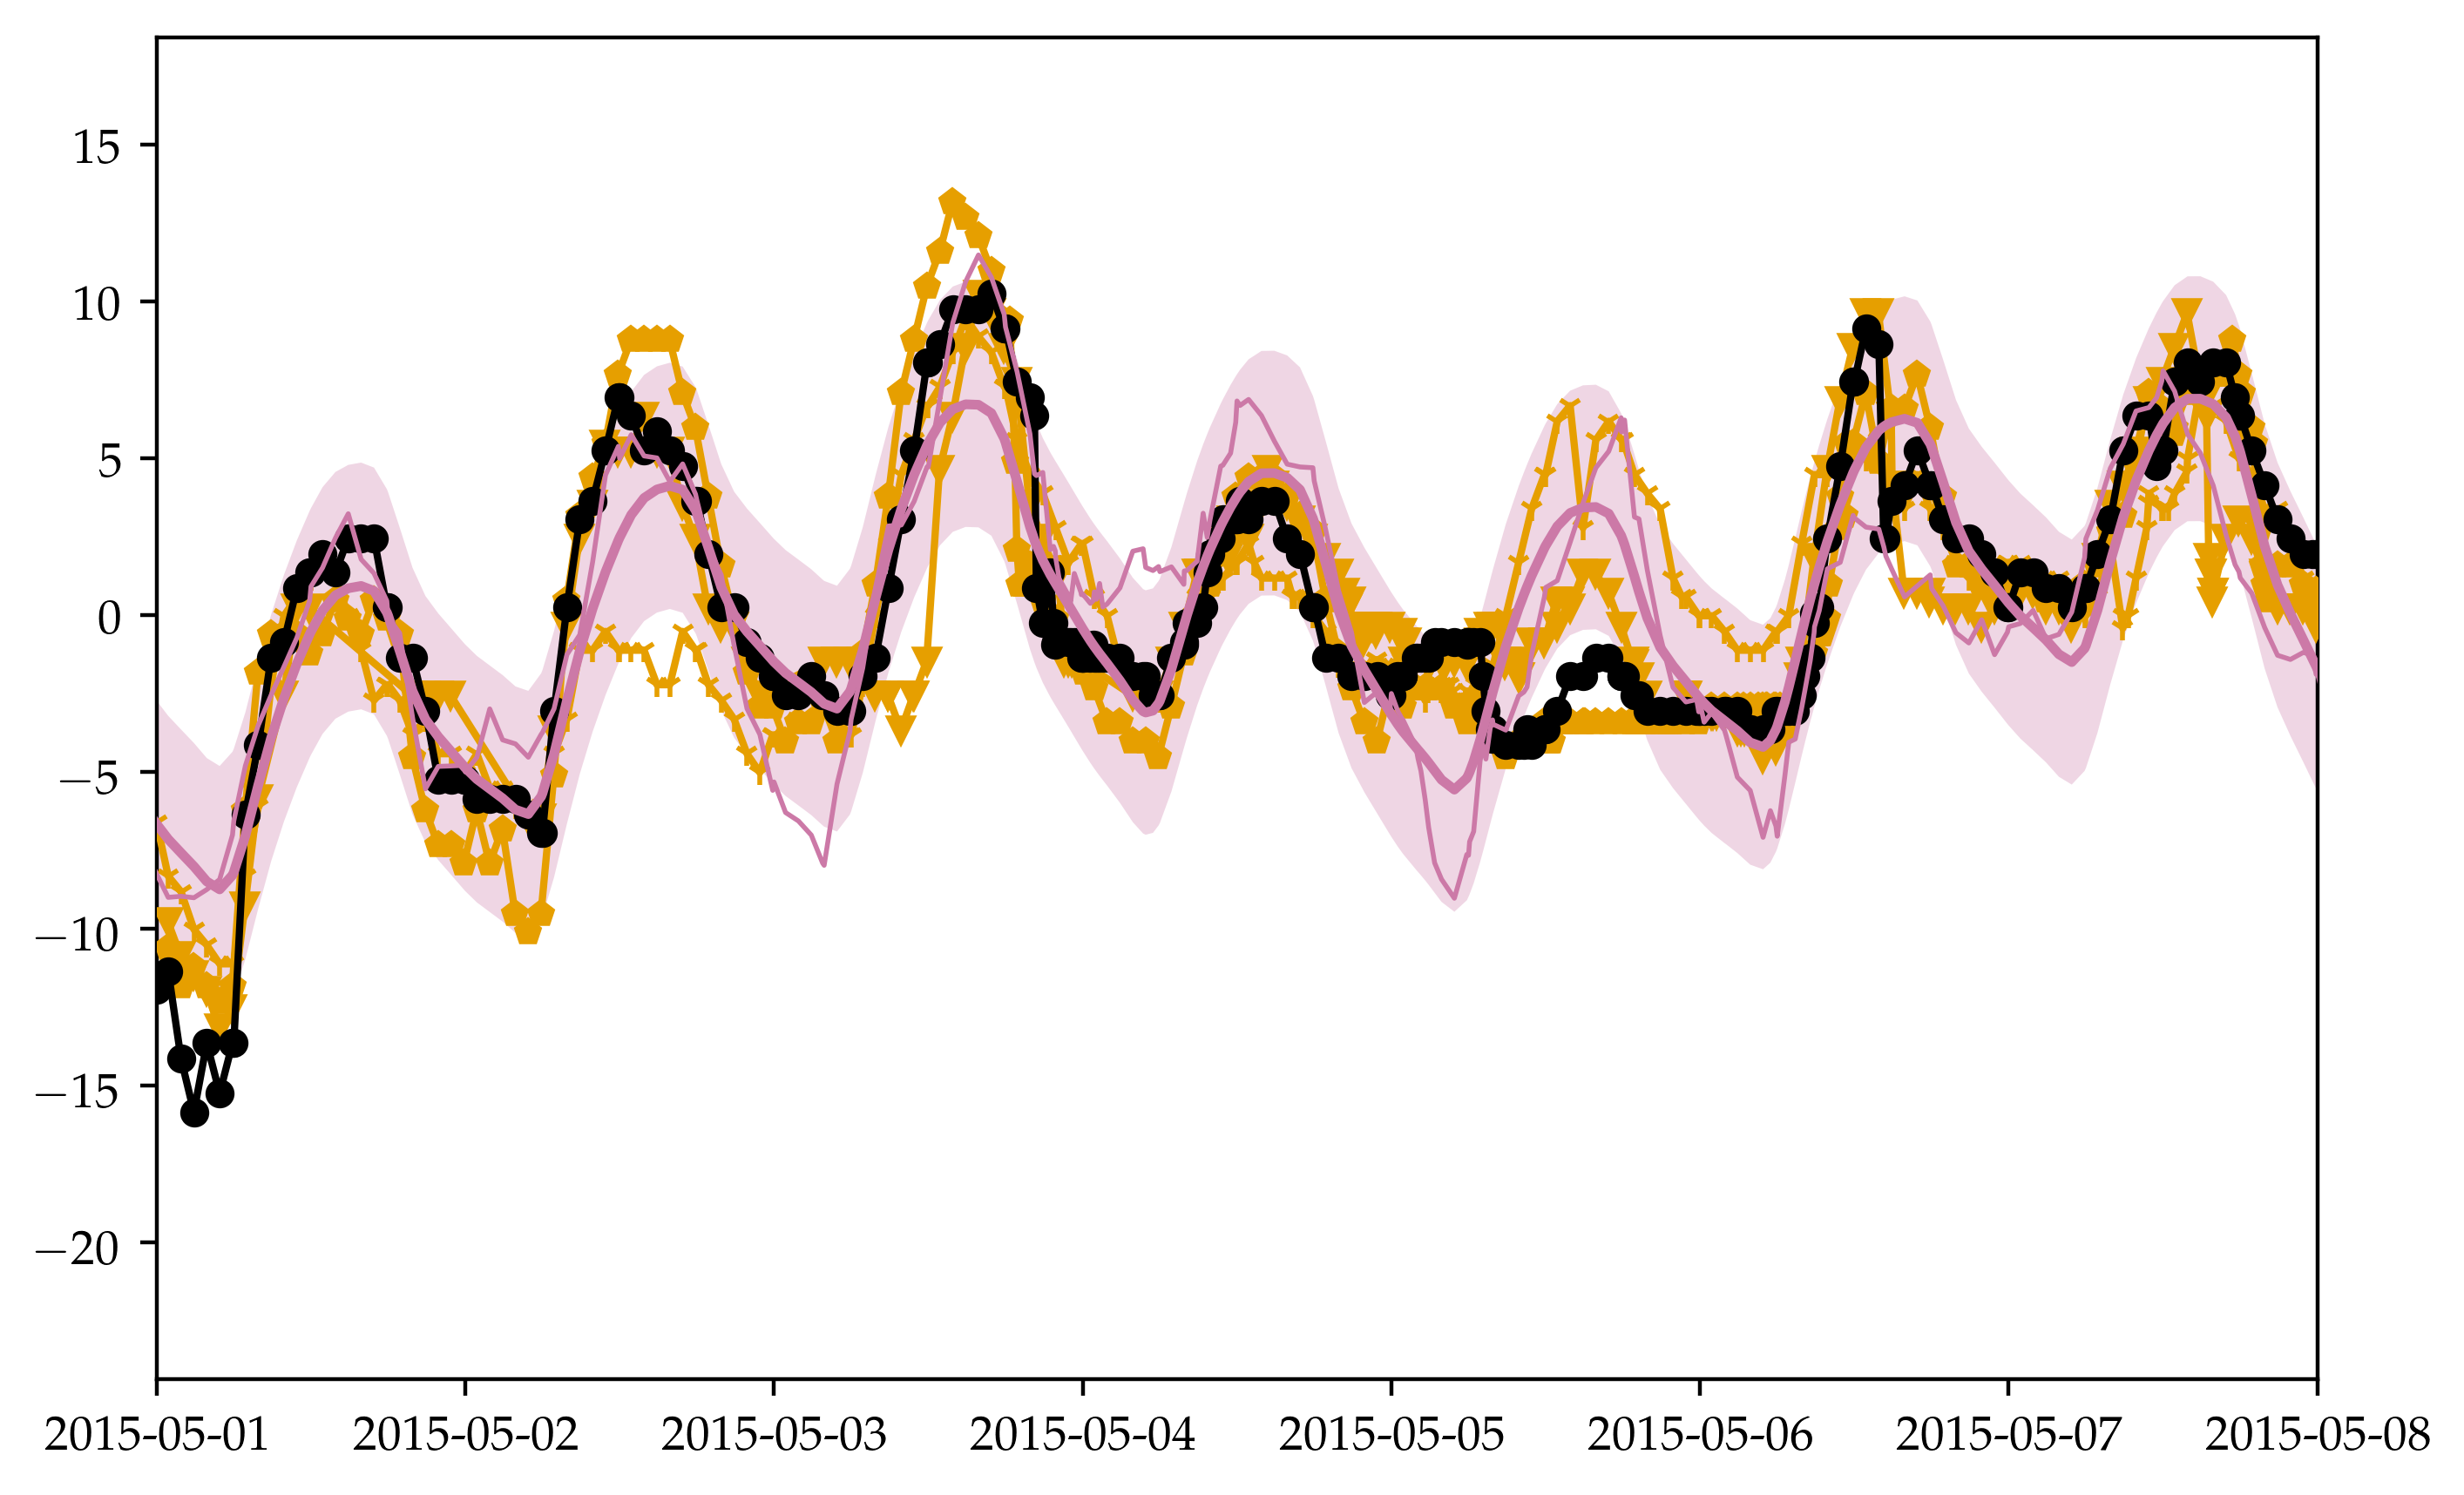

In [13]:
plot_pred("fixed_var", (DateTime(2015,5,1,6,0,0), DateTime(2015,5,8,6,0,0)))
;

In [14]:
print_diag("fixed_var")

var(predicted mean - simulated prediction)= 8.059
var(predicted mean - simulated prediction)= 8.626
var(predicted mean - simulated prediction)= 9.890
var(predicted mean - simulated prediction)= 8.826
var(predicted mean - simulated prediction)= 7.985
E(var(predicted mean - predictive draw))= 9.403
var(truth - predicted mean)= 6.091


var(truth - predicted mean)=6

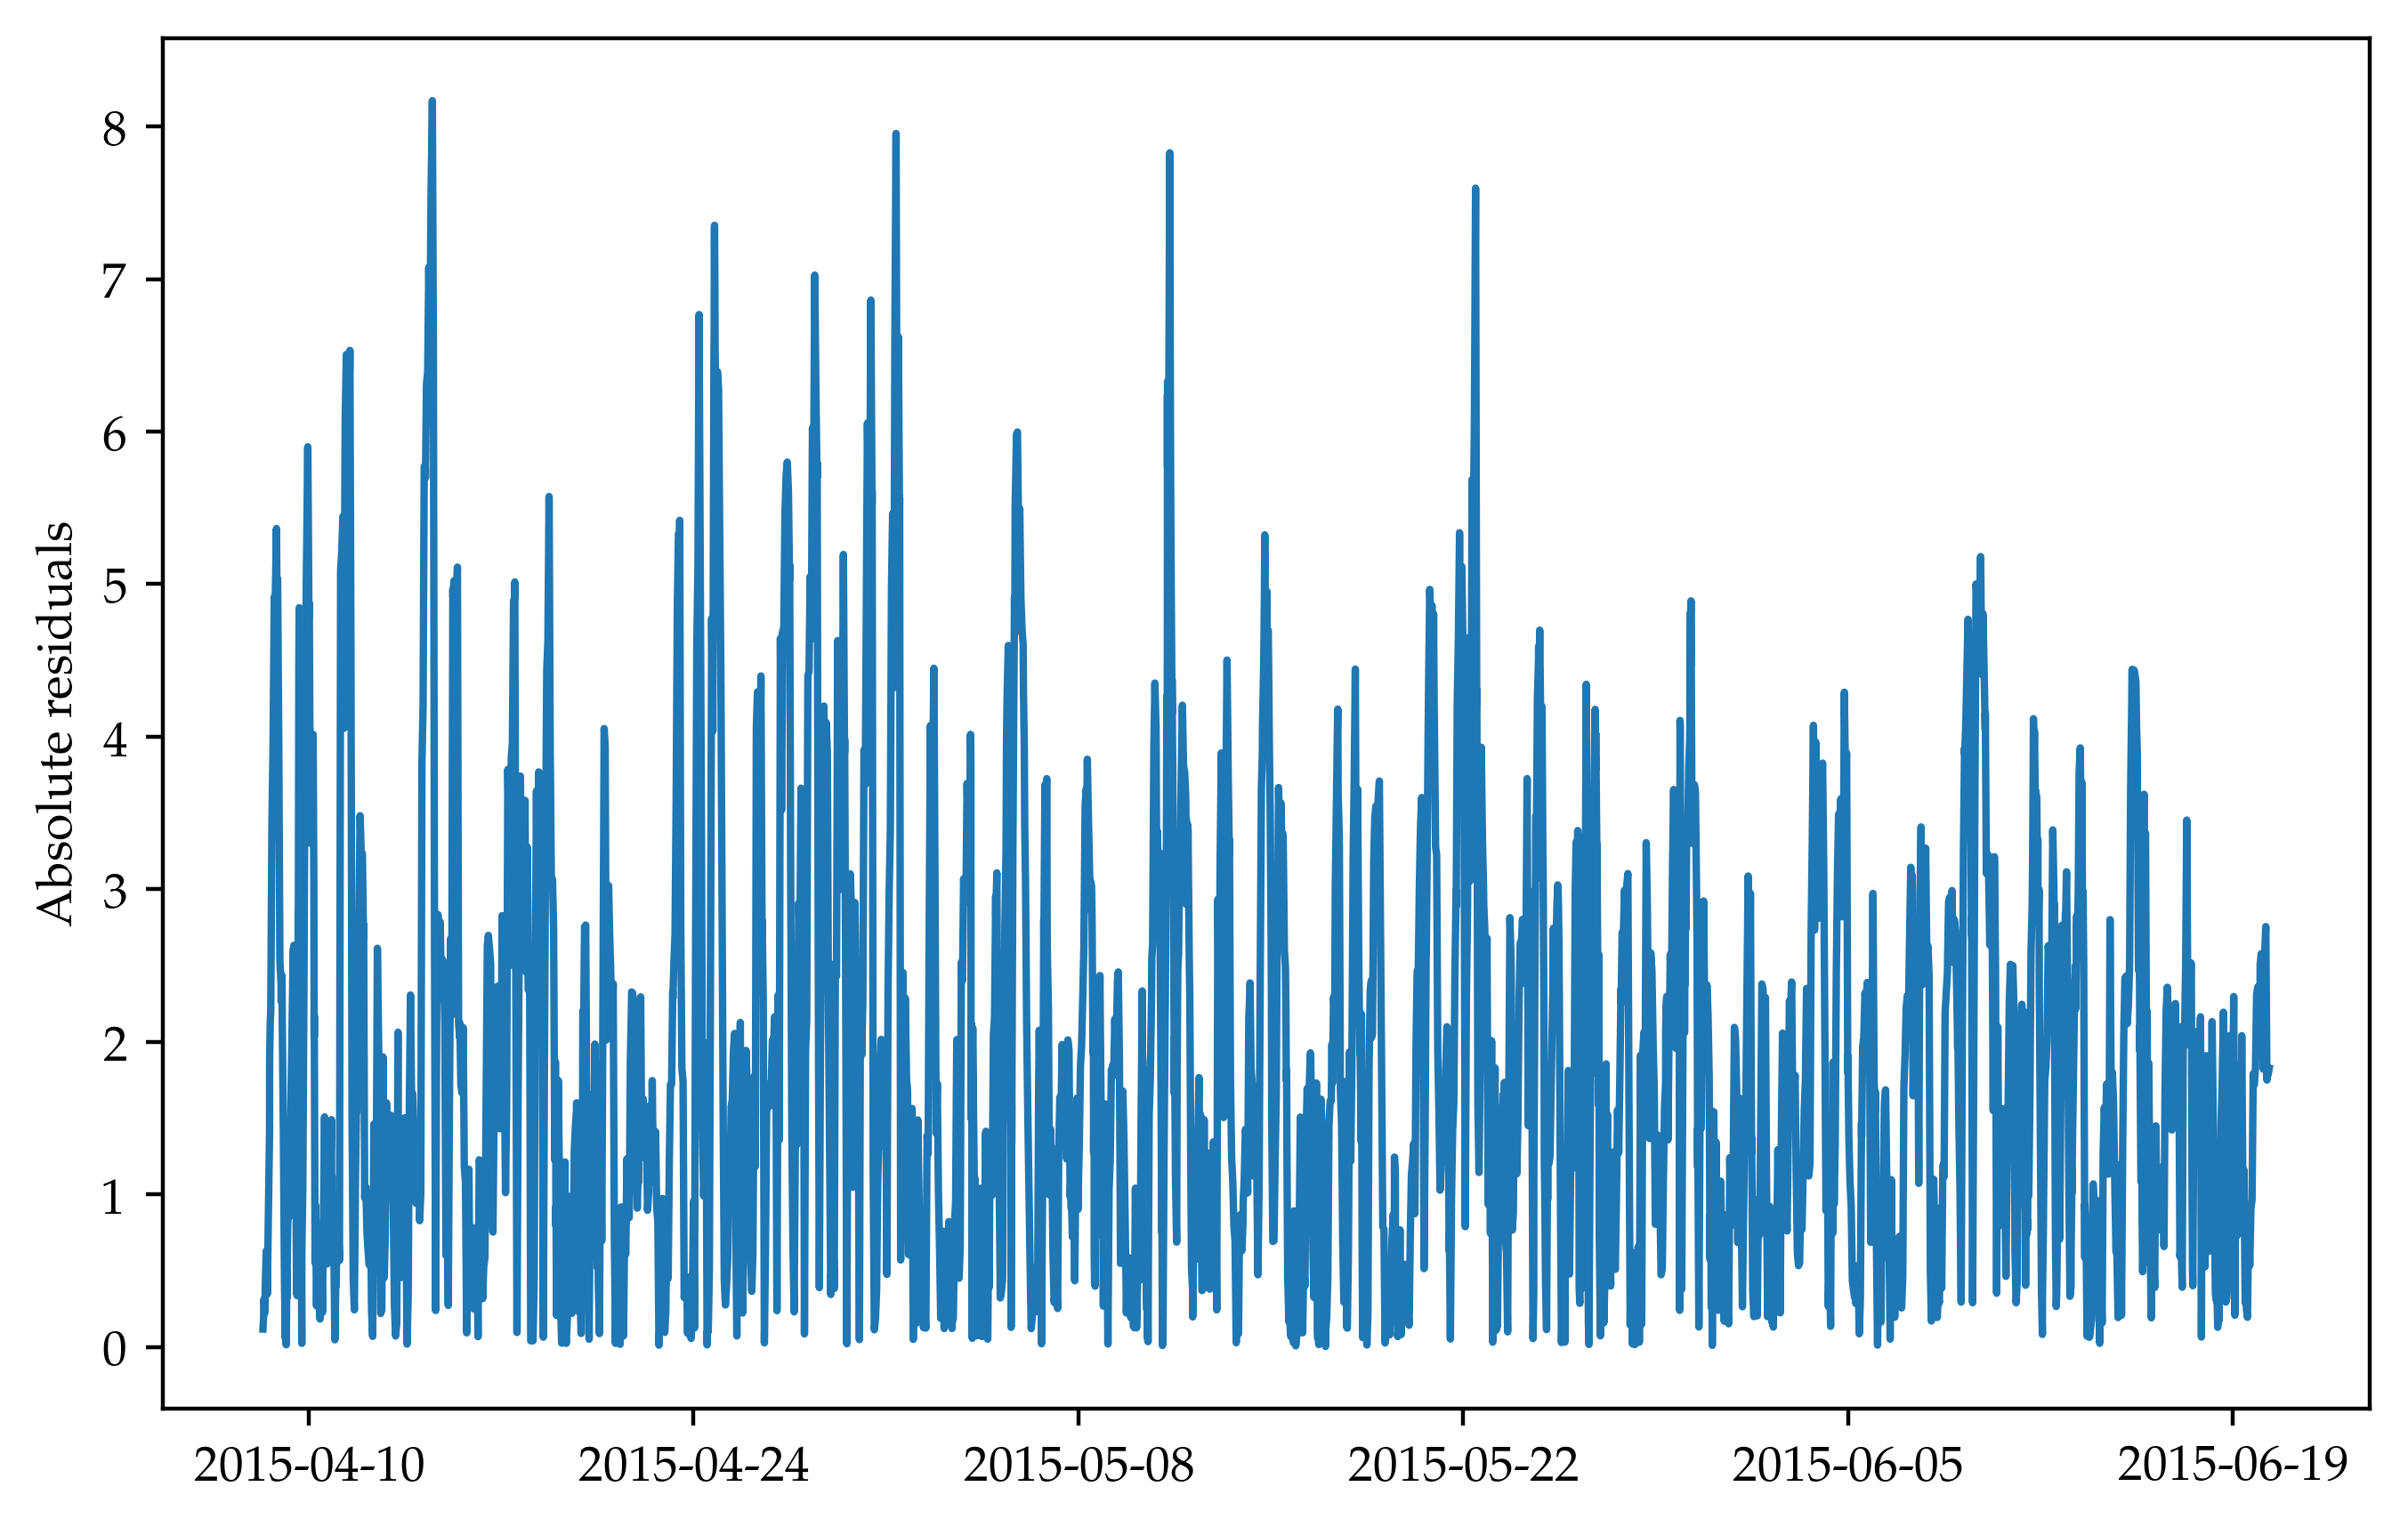

.090607796619108


PyObject Text(94,0.5,'Absolute residuals')

In [15]:
Batch.plot_residuals(nearby_pred, test_trimmed)

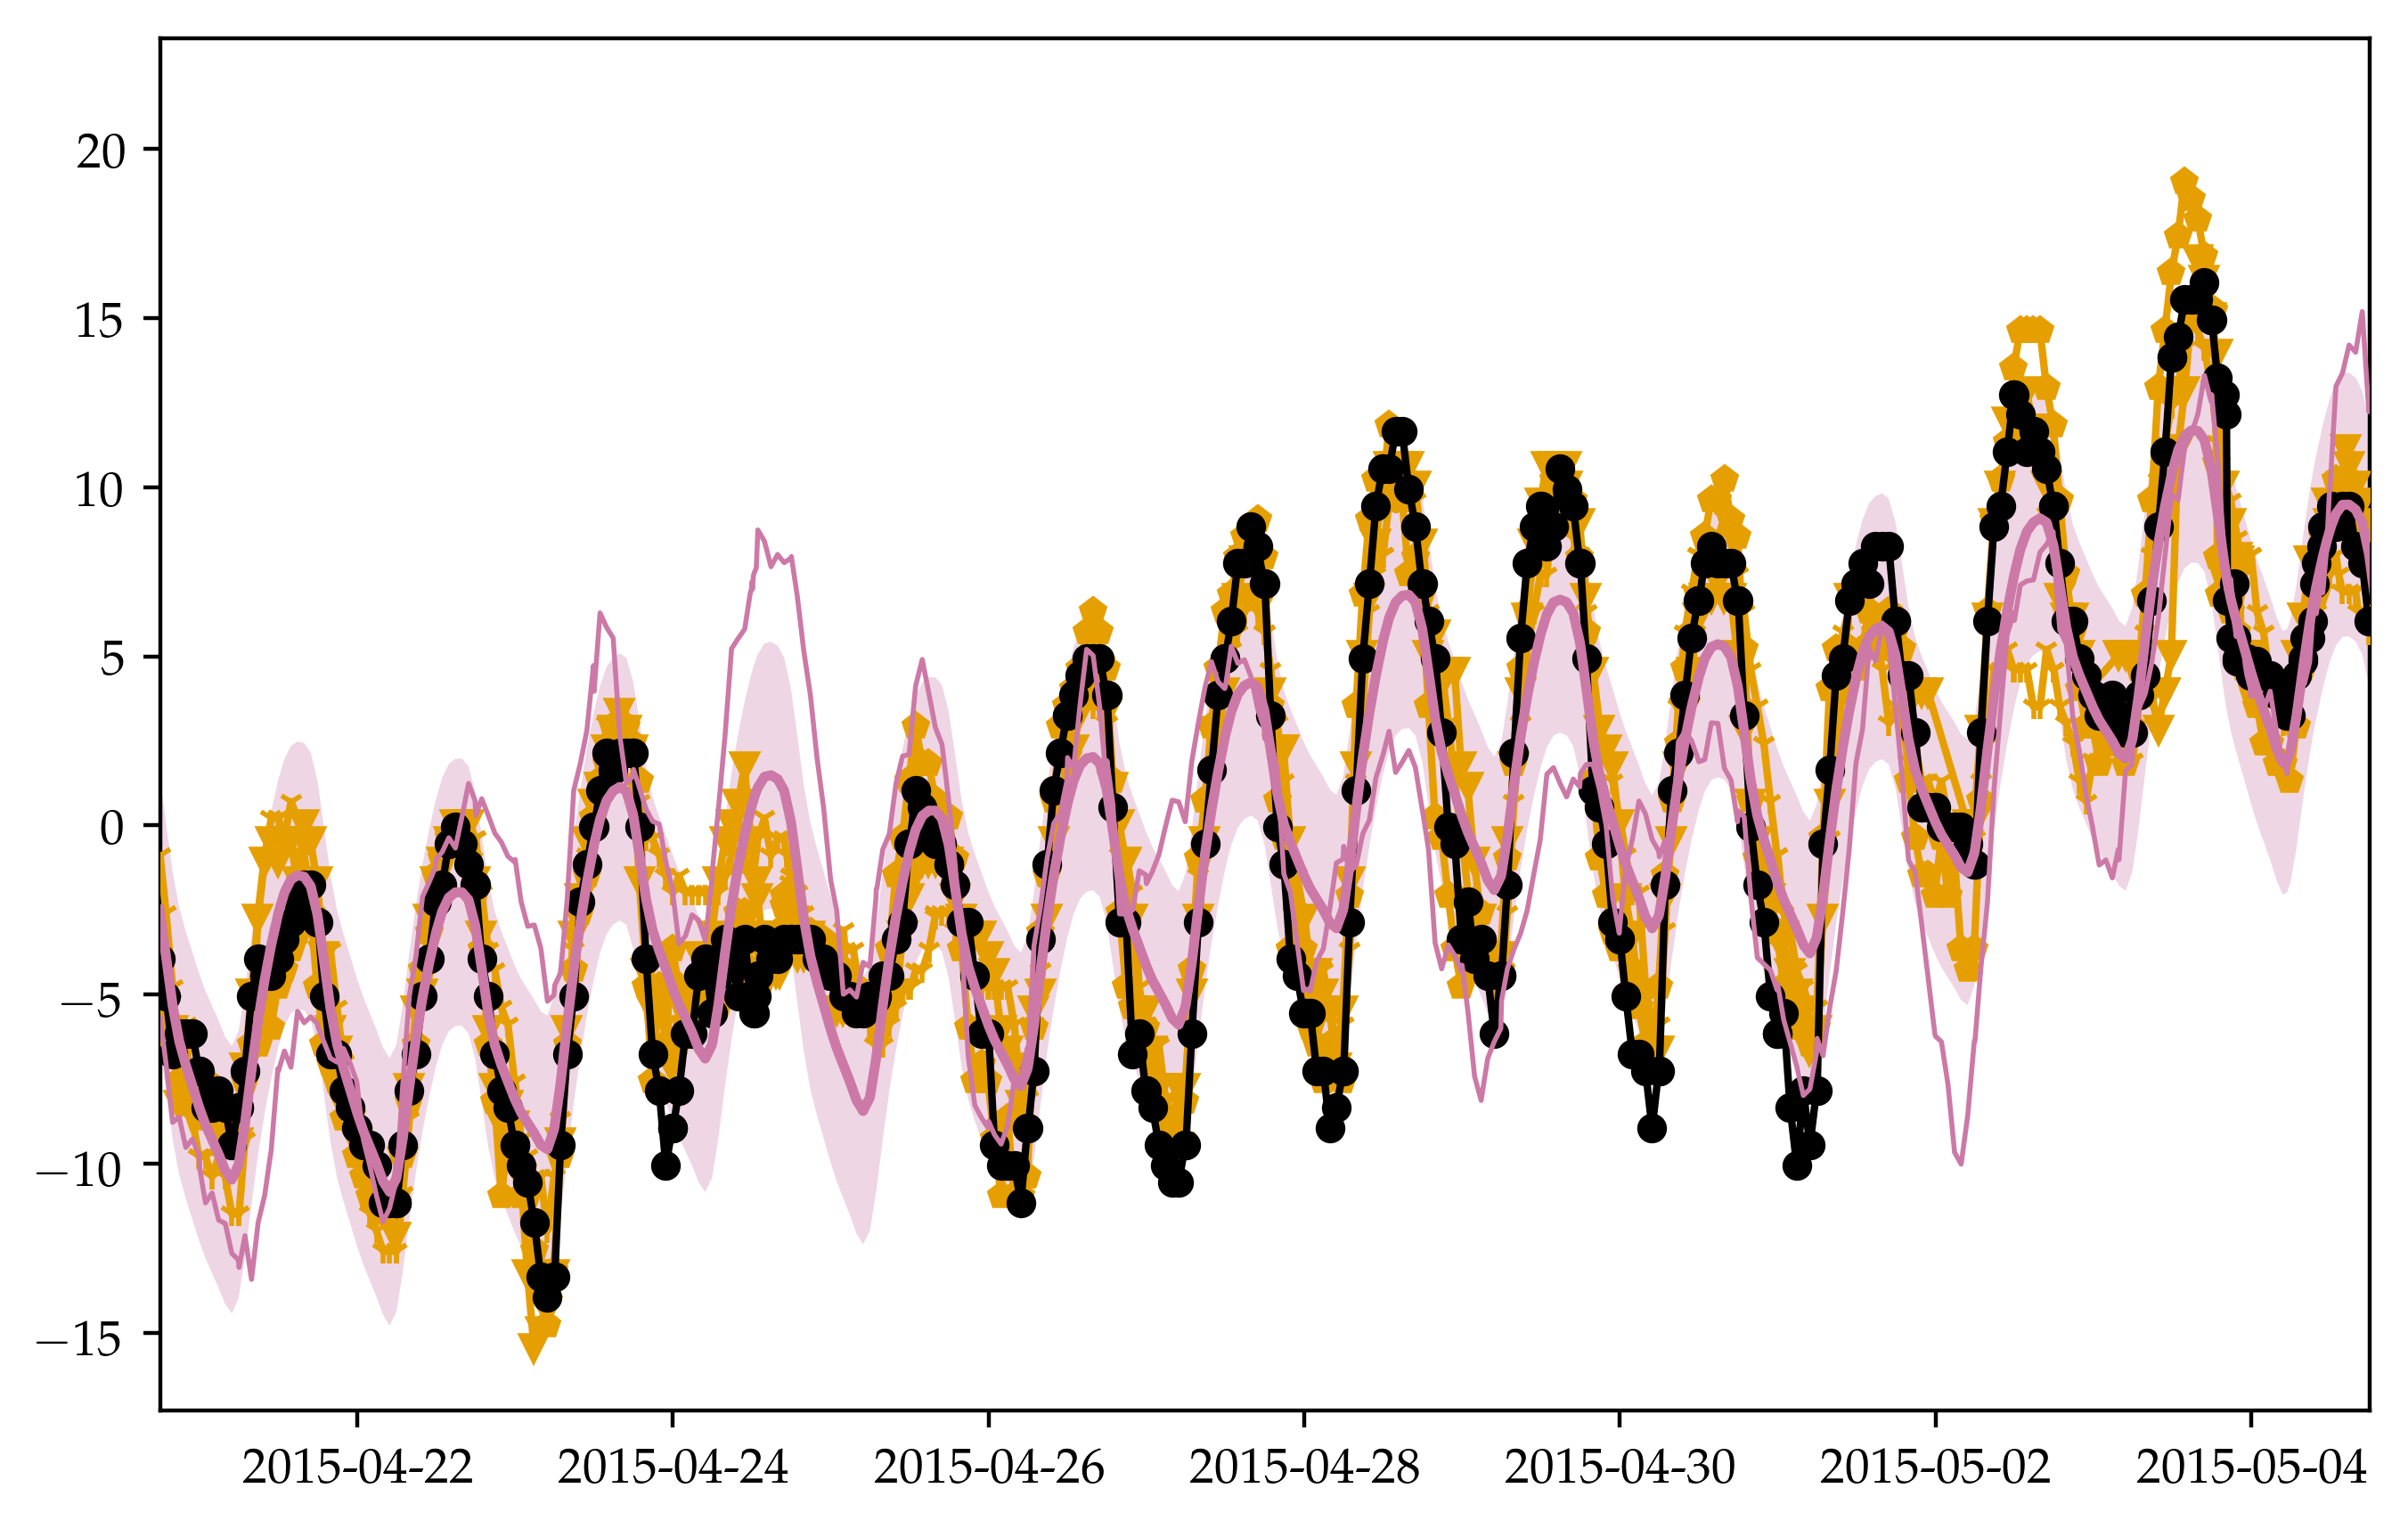

In [16]:
plot_pred("fixed_var", (DateTime(2015,4,21),DateTime(2015,5,5)))
;

## Sum of products, freed variances

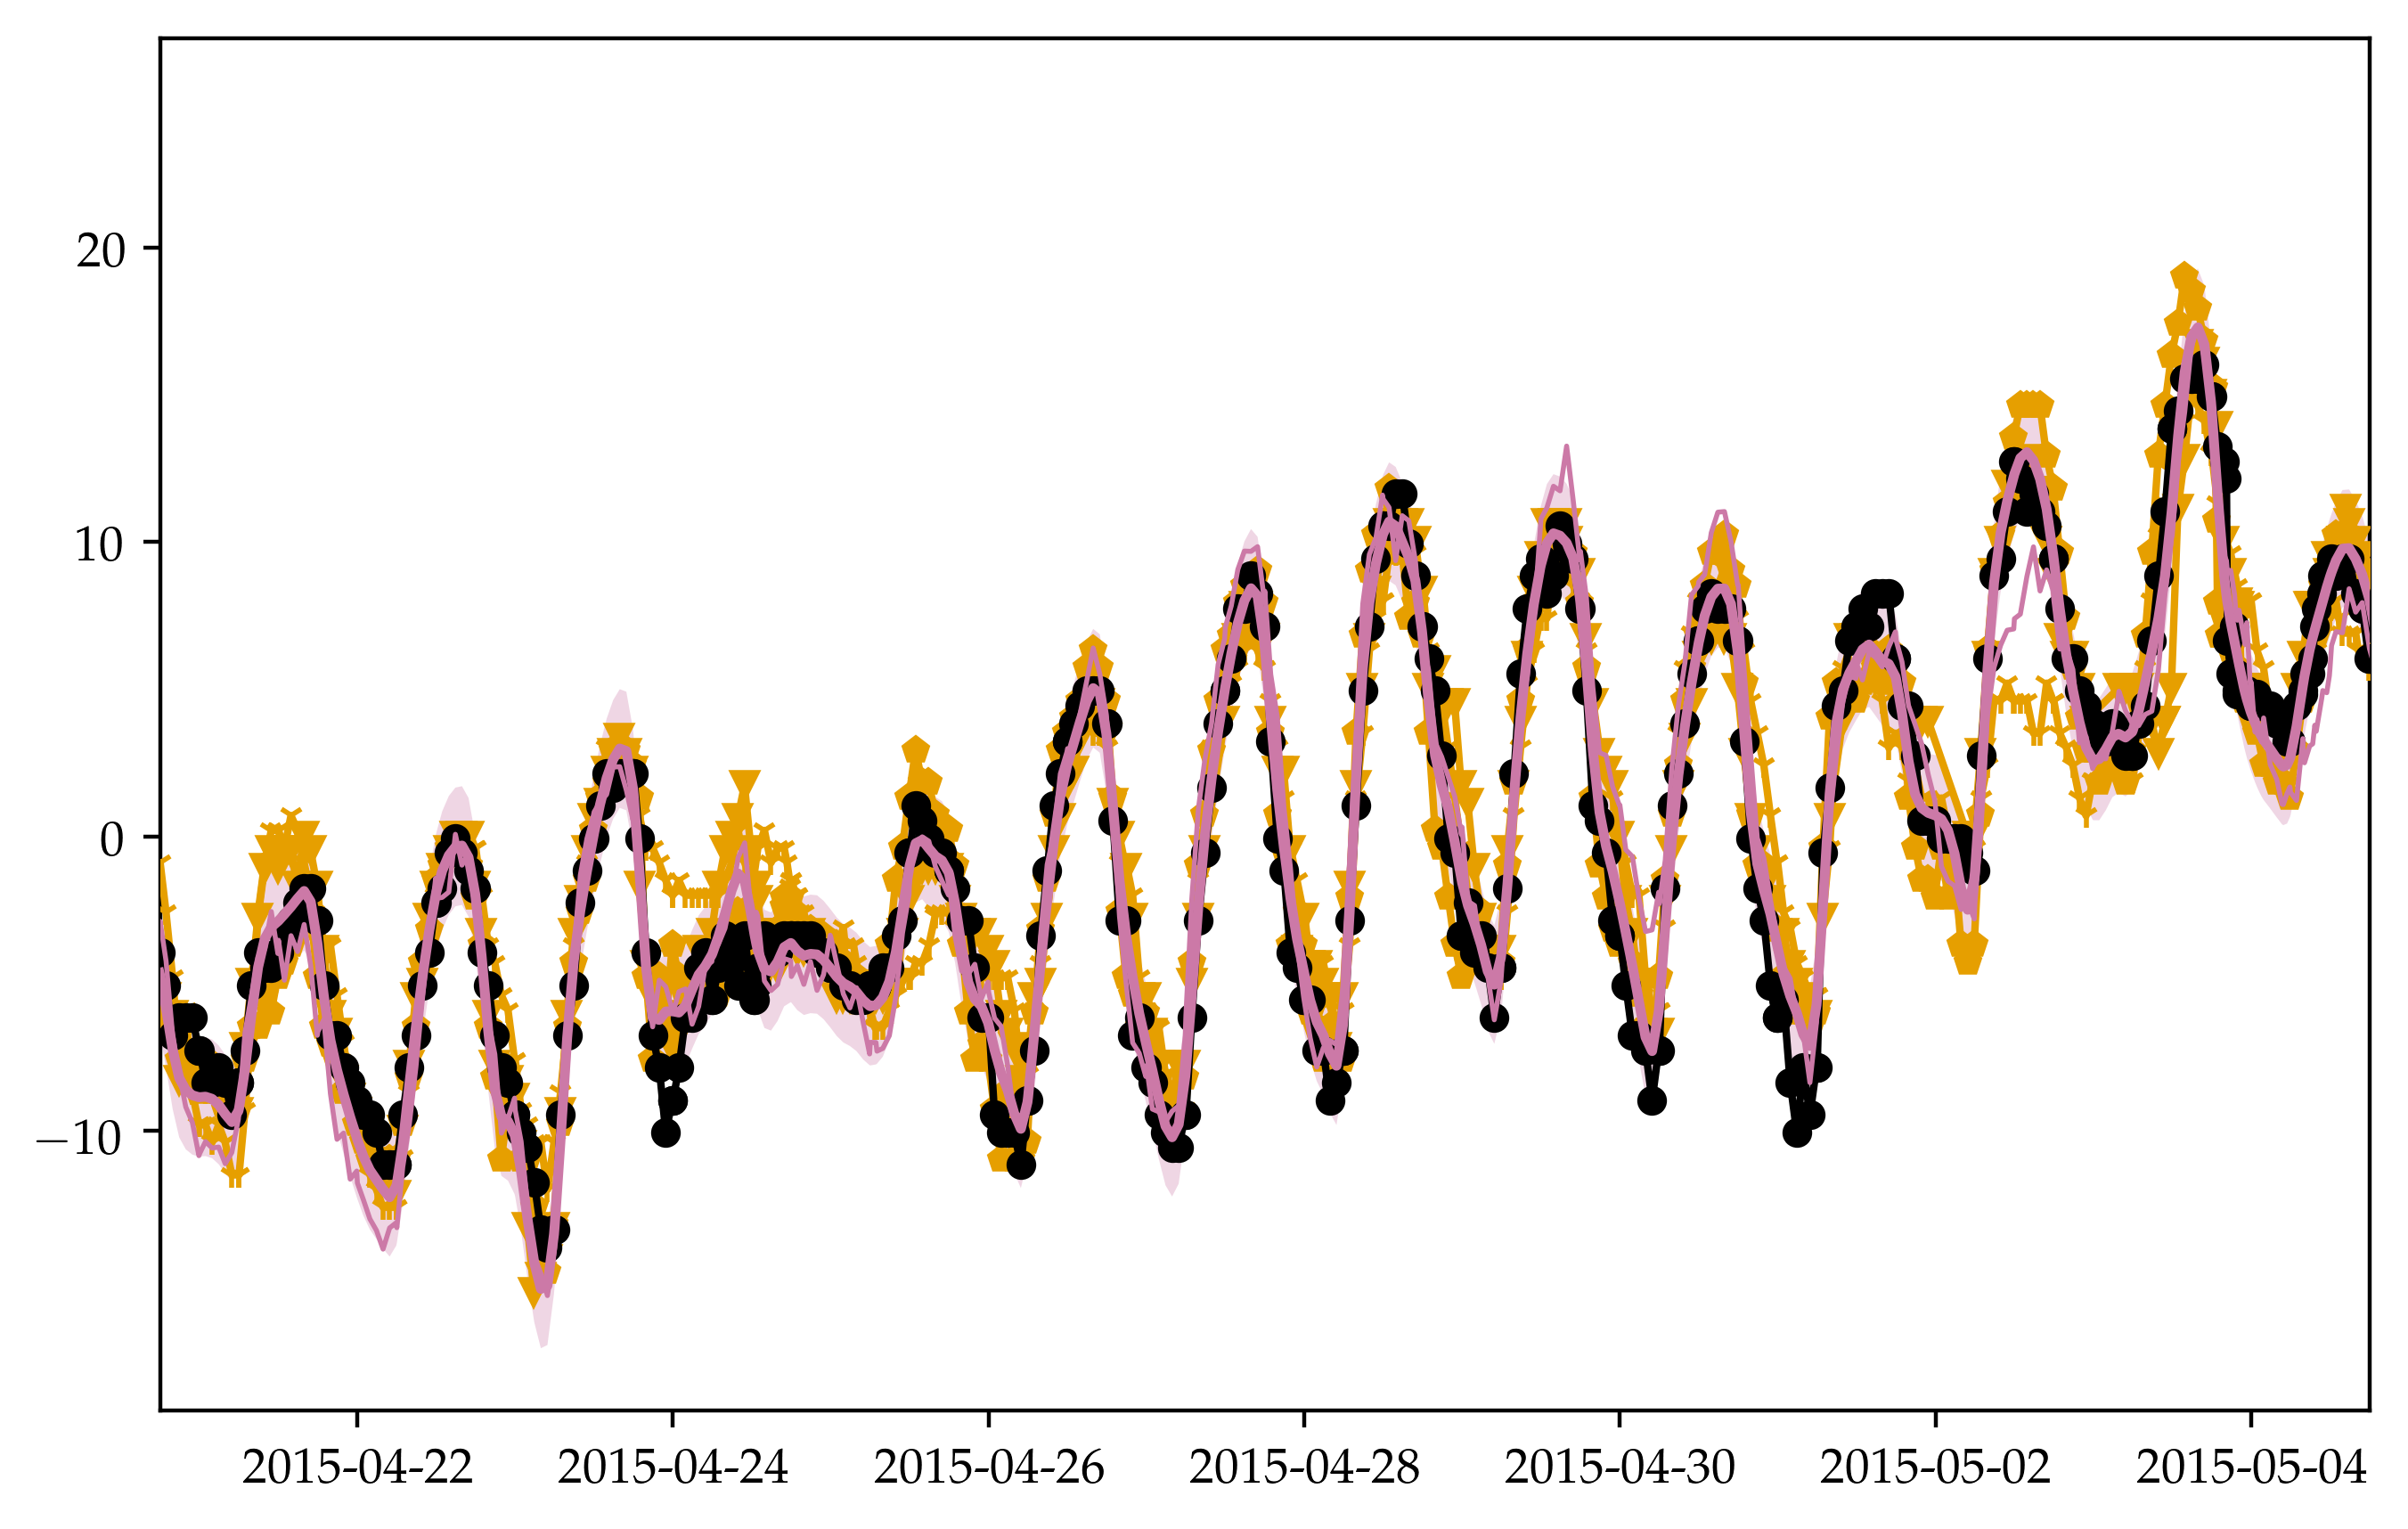

(735708.75, 735722.75)

In [17]:
plot_pred("free_var", (DateTime(2015,4,21),DateTime(2015,5,5)))

In [18]:
@time print_diag("free_var")

var(predicted mean - simulated prediction)= 2.511
var(predicted mean - simulated prediction)= 2.314
var(predicted mean - simulated prediction)= 2.415
var(predicted mean - simulated prediction)= 2.010
var(predicted mean - simulated prediction)= 2.063
E(var(predicted mean - predictive draw))= 2.456
var(truth - predicted mean)= 1.249
  2.867848 seconds (113.87 k allocations: 400.701 MiB, 13.47% gc time)


## Sum of products, all parameters free

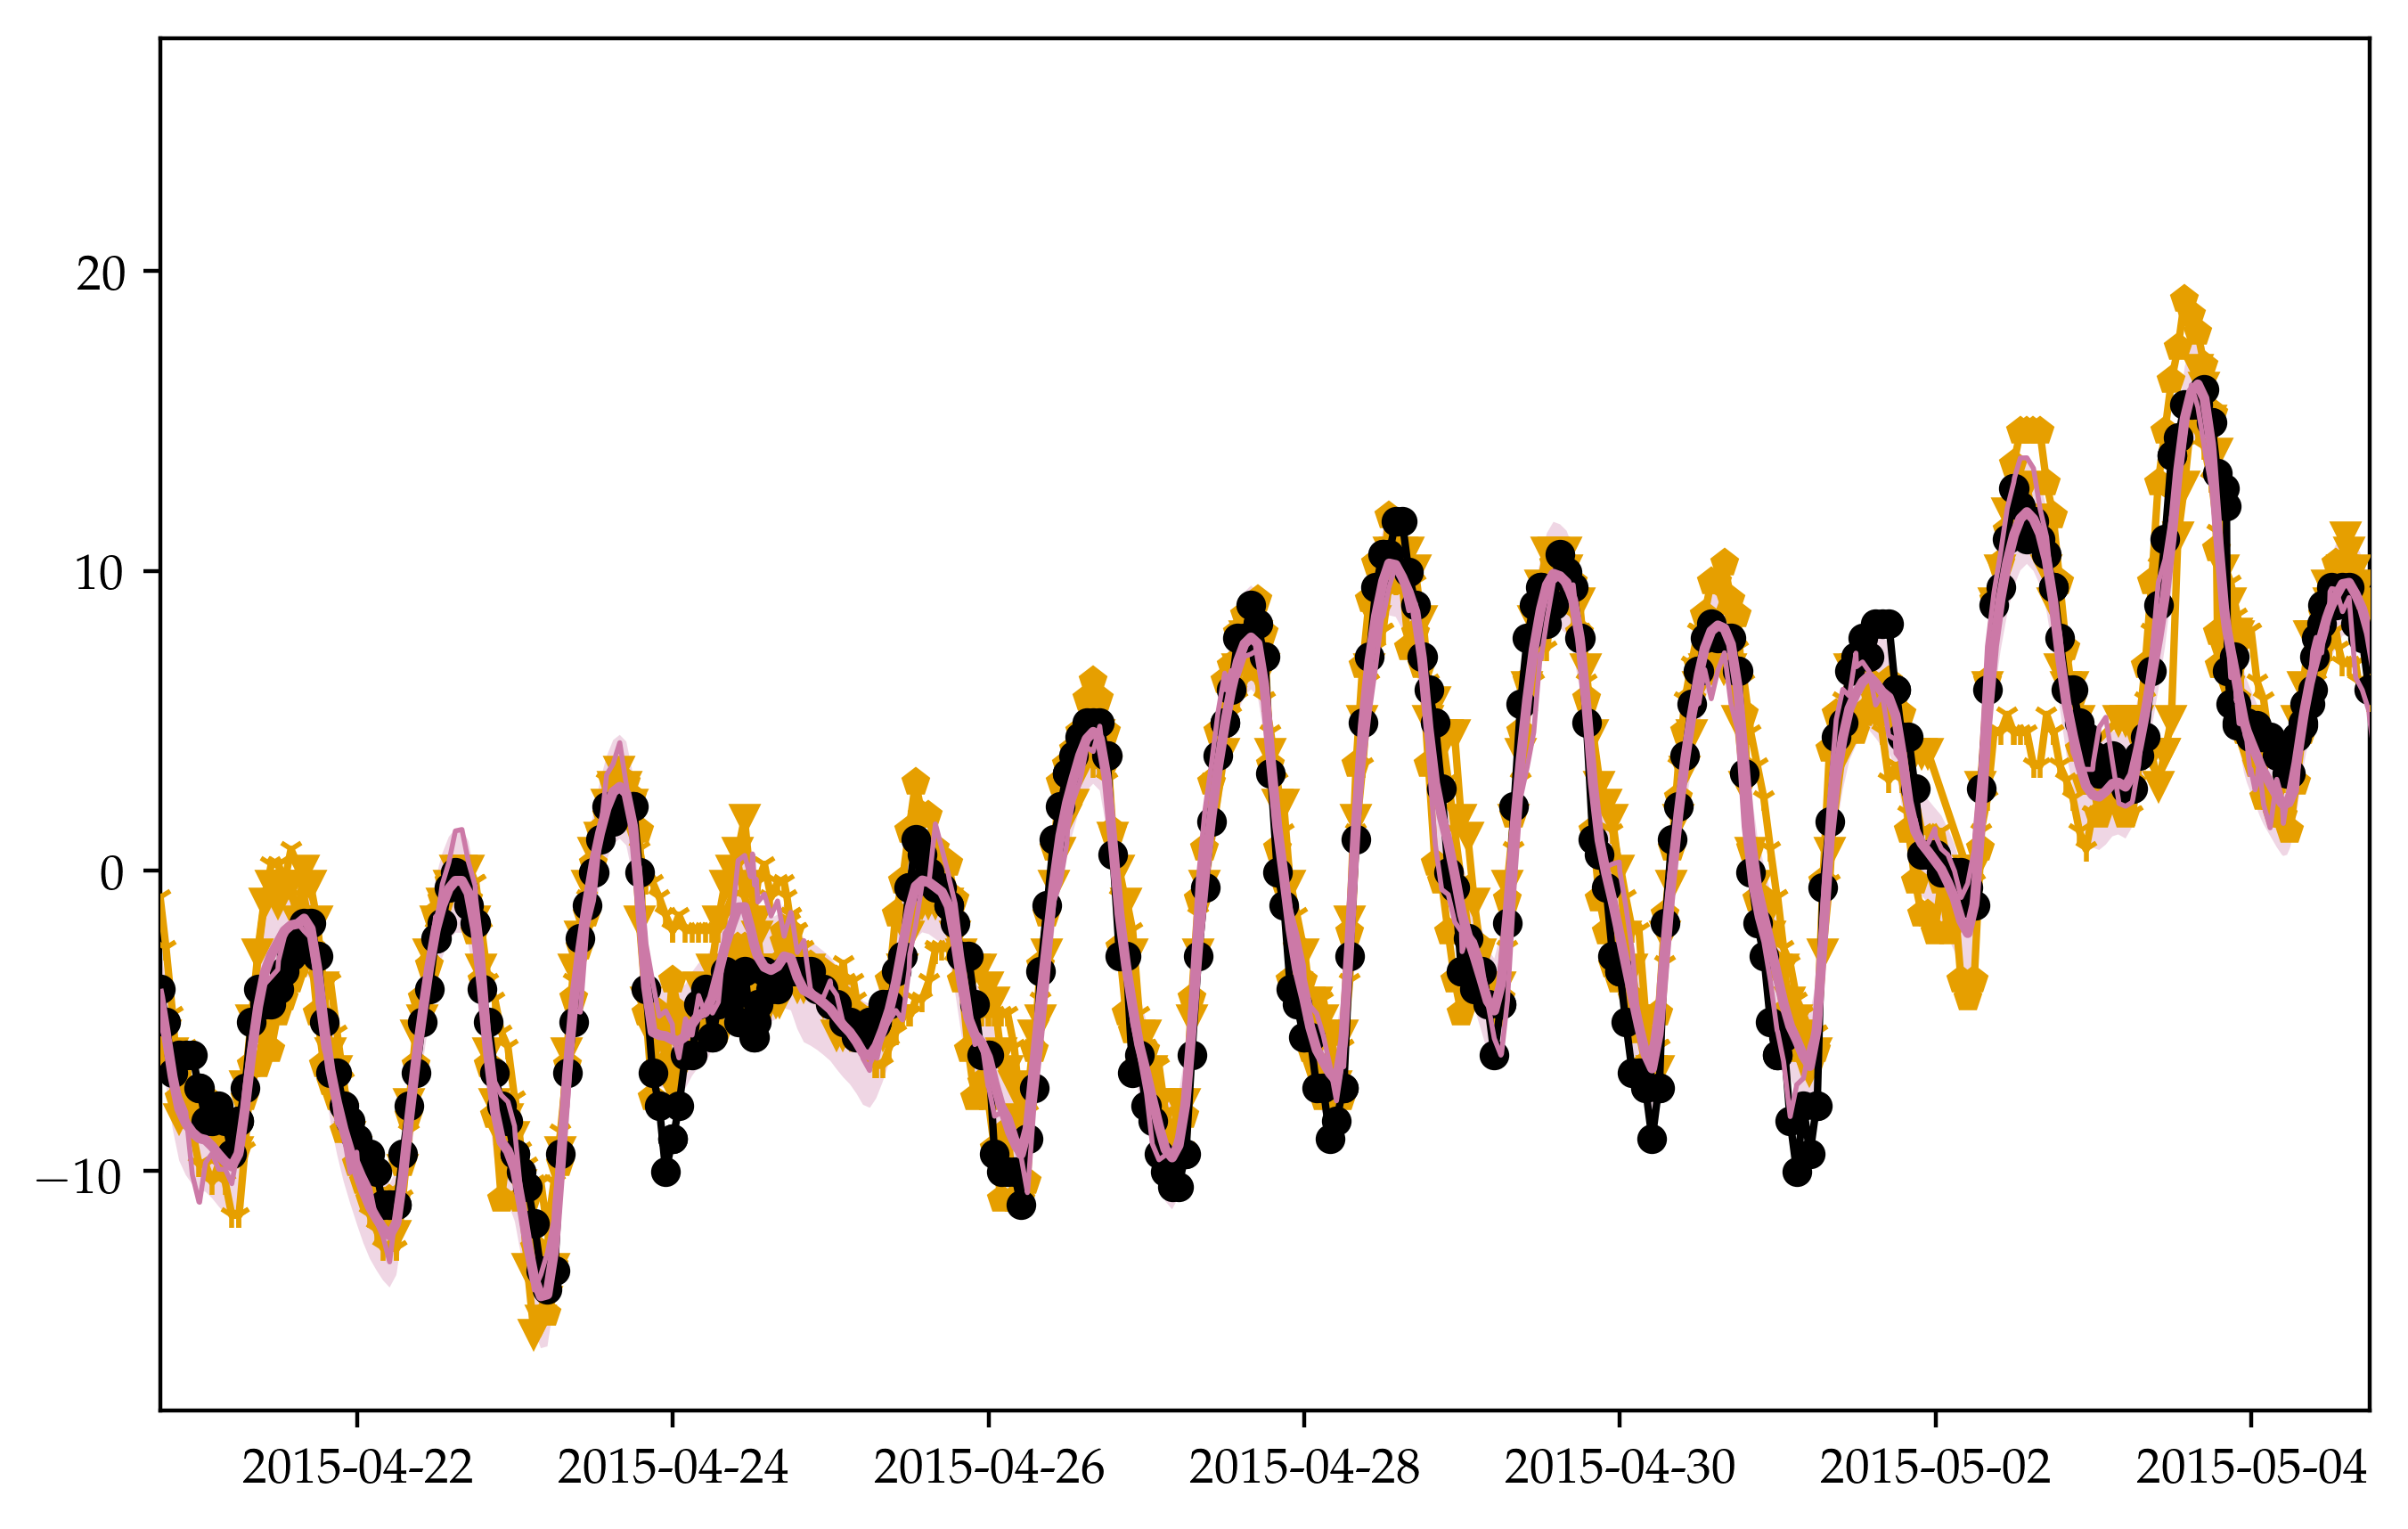

(735708.75, 735722.75)

In [19]:
plot_pred("sumprod", (DateTime(2015,4,21),DateTime(2015,5,5)))

In [20]:
print_diag("sumprod")

var(predicted mean - simulated prediction)= 1.747
var(predicted mean - simulated prediction)= 1.782
var(predicted mean - simulated prediction)= 1.728
var(predicted mean - simulated prediction)= 1.831
var(predicted mean - simulated prediction)= 1.994
E(var(predicted mean - predictive draw))= 1.818
var(truth - predicted mean)= 1.377


Annoyingly, we again see that even though this model has more free parameters, and the marginal likelihood was significantly lower (when we optimized all the parameters), the predictive variance is actually worse (higher).

## Simpler

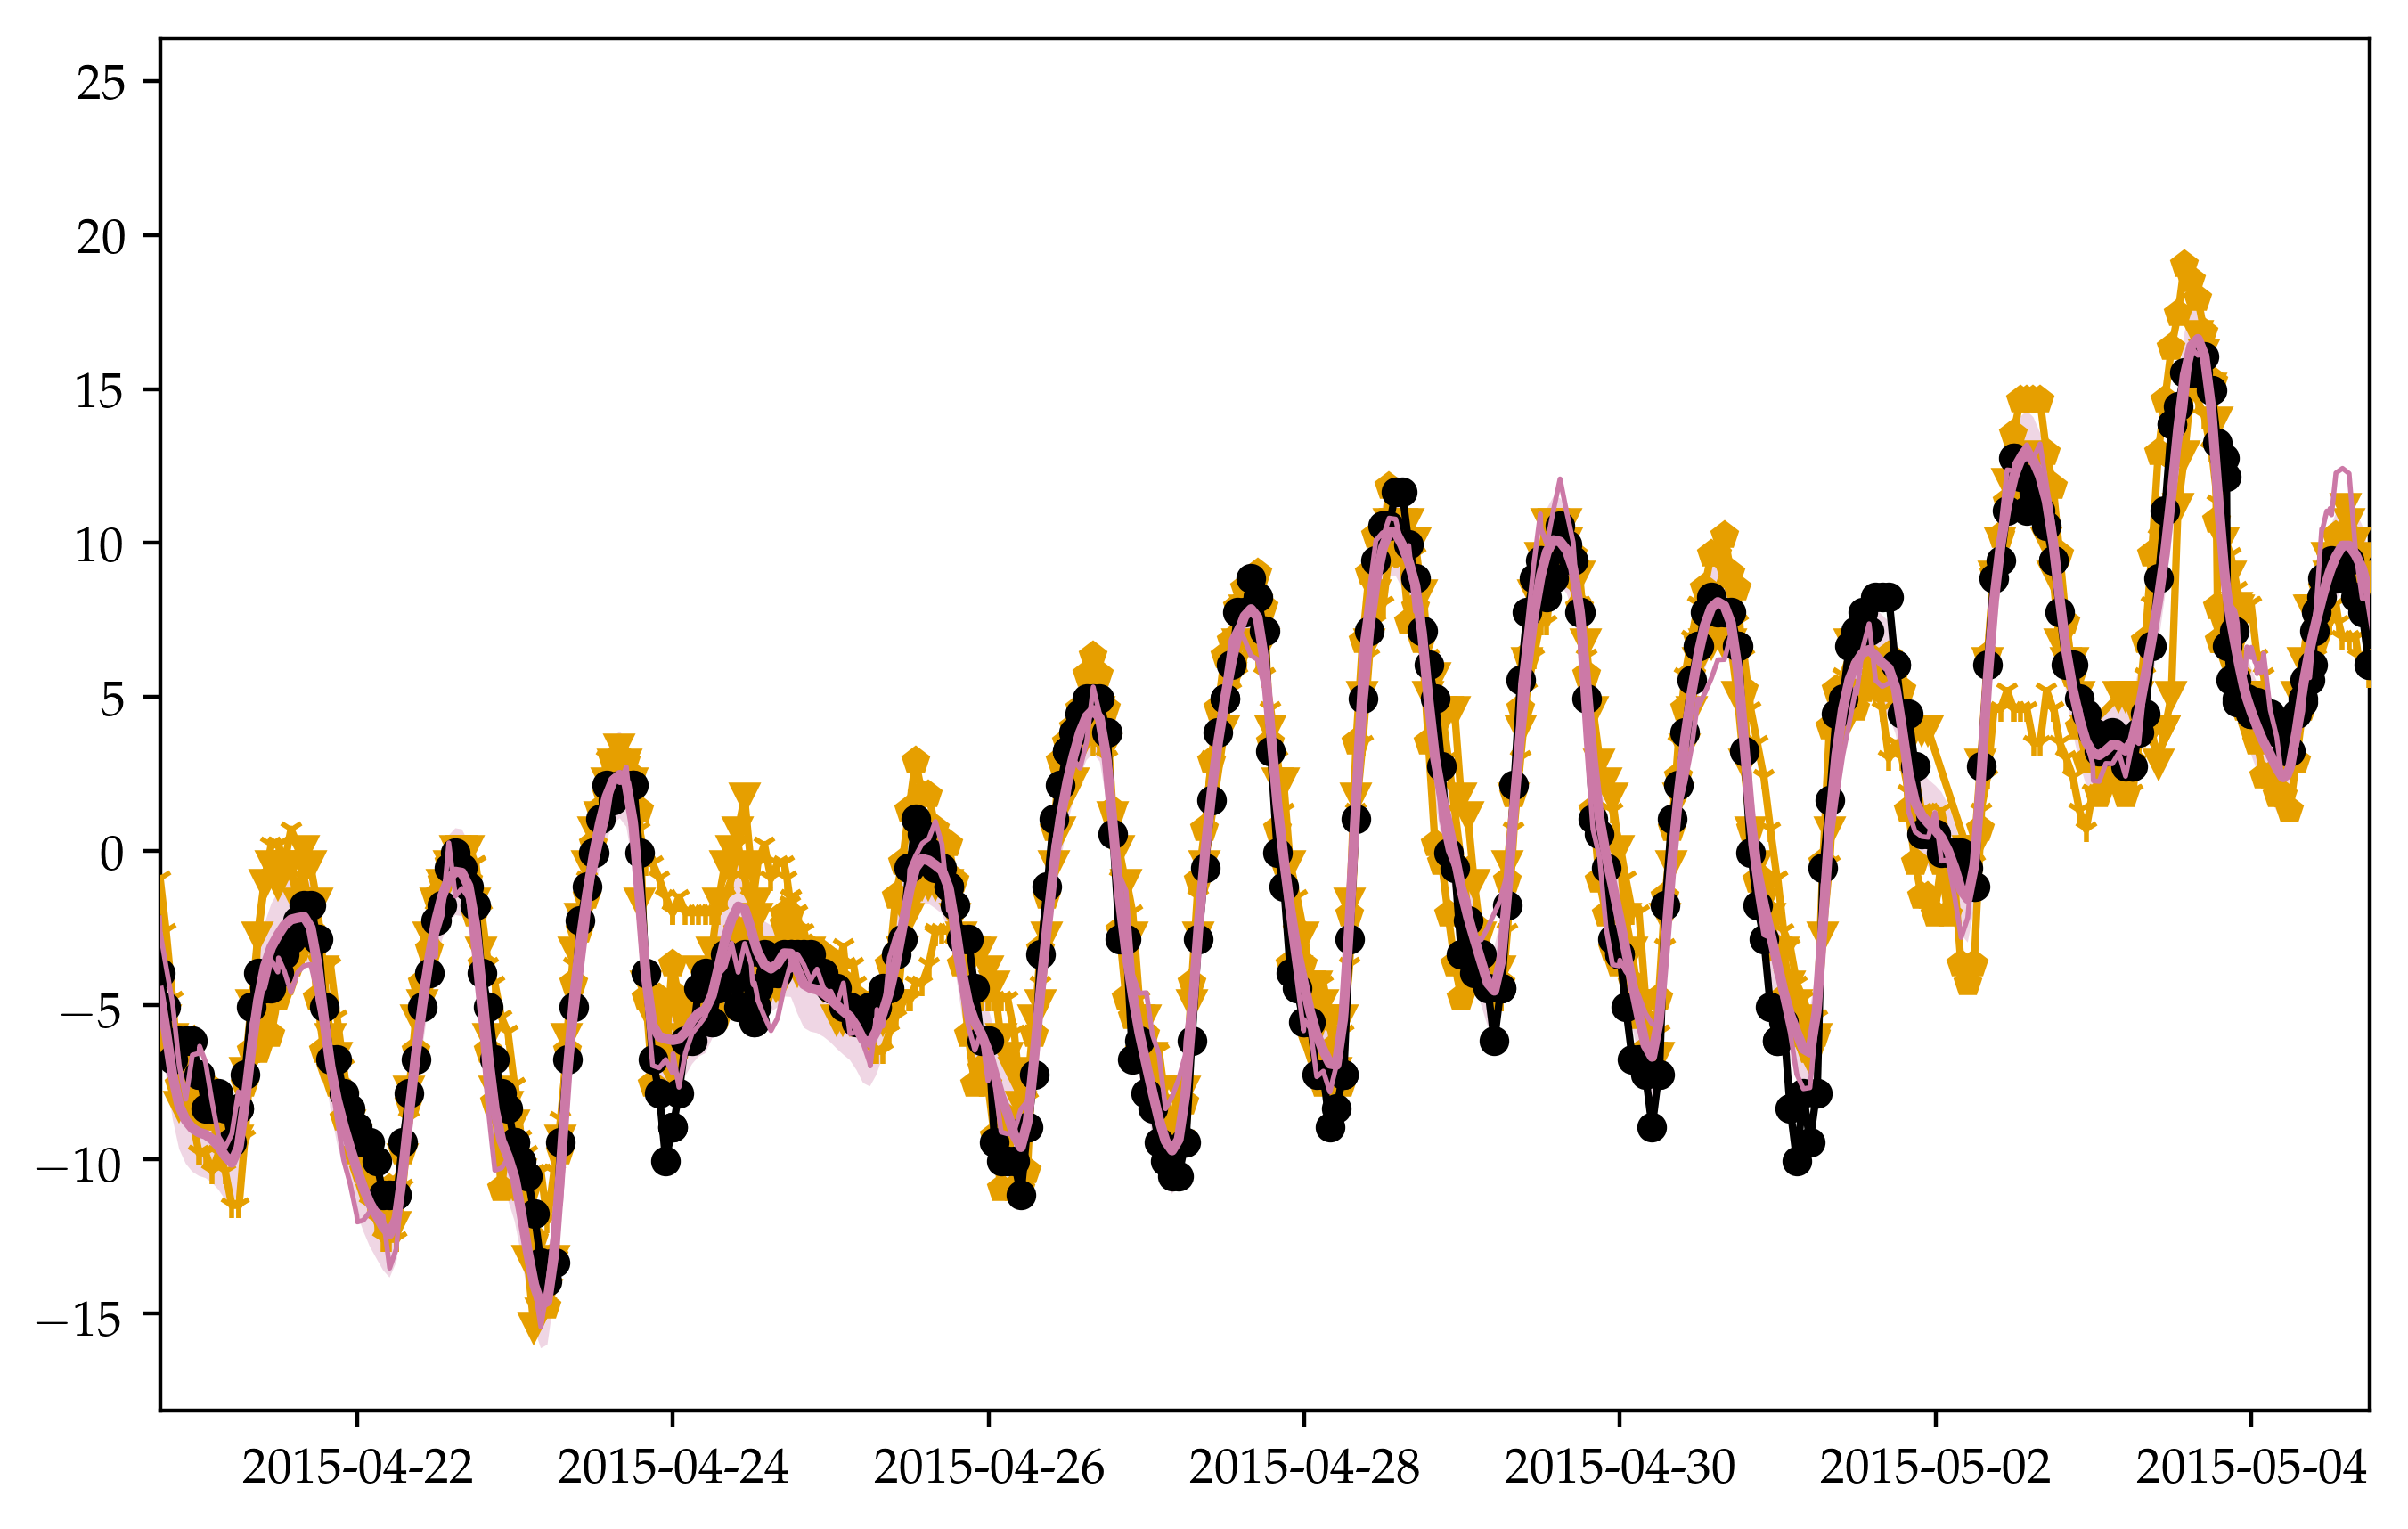

(735708.75, 735722.75)

In [21]:
plot_pred("simpler", (DateTime(2015,4,21),DateTime(2015,5,5)))

In [22]:
print_diag("simpler")

var(predicted mean - simulated prediction)= 1.246
var(predicted mean - simulated prediction)= 1.091
var(predicted mean - simulated prediction)= 1.304
var(predicted mean - simulated prediction)= 1.161
var(predicted mean - simulated prediction)= 1.126
E(var(predicted mean - predictive draw))= 1.200
var(truth - predicted mean)= 1.277


# STAN Imputations

In [23]:
function plot_imput(GPmodel)
    window_num = 40
    stan_fw = Batch.get_window(window_num)
    hr_measure = Hour(17)
    chains, _ts = Batch.get_chains_and_ts(stan_fw, GPmodel, test_usaf)
    temp_impute = Batch.get_temperatures_reparam(chains)
    test_subsubset = Batch.get_test_fw(test_trimmed, stan_fw, hr_measure)

    Batch.plot_truth(test_subsubset, stan_fw, hr_measure, iowa_time; tntx=true)
    Batch.plot_imputations(test_subsubset[:ts], temp_impute, iowa_time)
    plt.plot(iowa_time.(_ts), temp_impute[500,:,1],
        color="#009F77")

    plt.legend(loc="best", fontsize="small")
    plt.title(@sprintf("Imputed %s data", titlecase(lowercase(isdSubset[itest,:NAME]))))
    plt.xlim(Date(2015,5,2), Date(2015,5,5))
end

plot_imput (generic function with 1 method)

In [24]:
function imput_diag(GPmodel)
    window_num = 40
    stan_fw = Batch.get_window(window_num)
    hr_measure = Hour(17)
    chains, _ts = Batch.get_chains_and_ts(stan_fw, GPmodel, test_usaf)
    diagn = Batch.ImputationDiagnostic(0.0, 0.0, 0)
    temp_impute = Batch.get_temperatures_reparam(chains)
    test_subsubset = Batch.get_test_fw(test_trimmed, stan_fw, hr_measure)
    diagn += Batch.ImputationDiagnostic(temp_impute, test_subsubset)
    @printf("E(var(predicted mean - predictive draw))=%.5f\n", Batch.EVarError(diagn))
    @printf("MSE(truth - predicted mean)=             %.5f\n", Batch.mse(diagn))
end

imput_diag (generic function with 1 method)

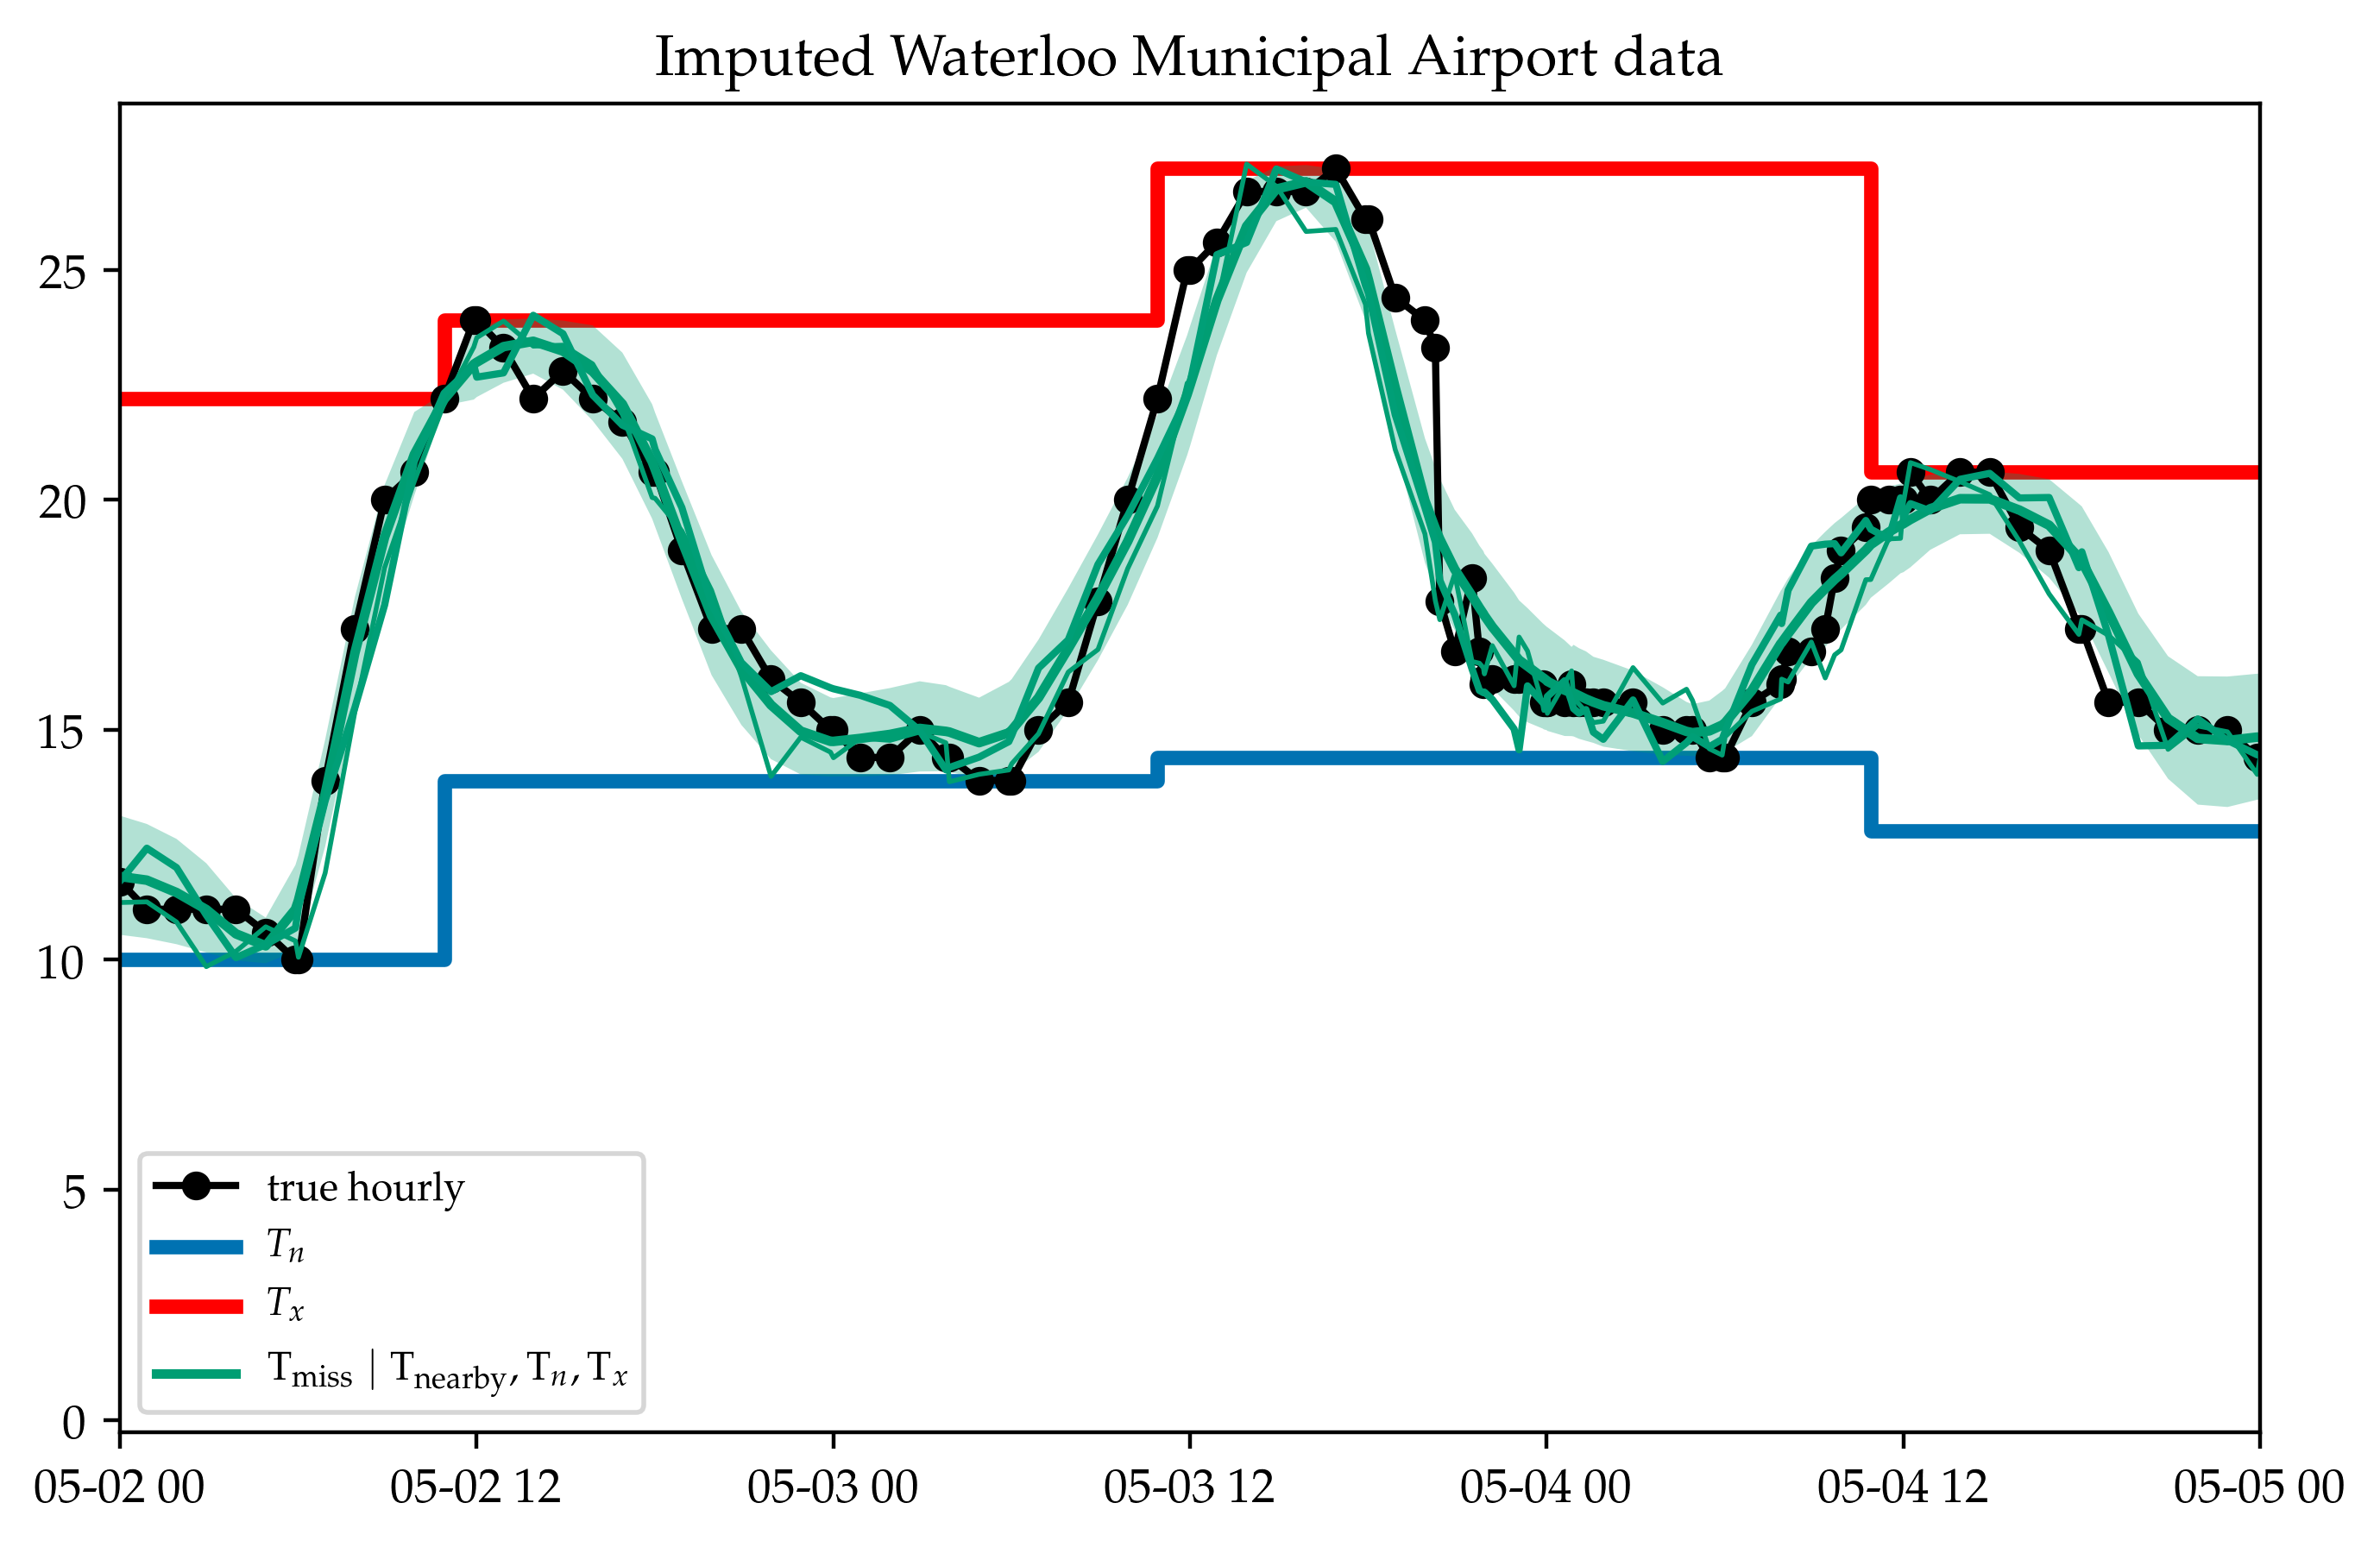

In [25]:
plot_imput("simpler")

plt.savefig("../figures/imputations_simpler.png", bbox_inches="tight")
plt.savefig("../figures/imputations_simpler.pdf", bbox_inches="tight")
;

In [26]:
imput_diag("simpler")

E(var(predicted mean - predictive draw))=0.82730
MSE(truth - predicted mean)=             1.24456


# 2x2 plot of imputations

In [27]:
plot_nearby = function(GPmodel, xlim1, xlim2)
    nearby_pred = Batch.get_nearby(test_fw, GPmodel, test_usaf)
    test_data = test_trimmed
    train_data = hourly_train
    stations_metadata = isdSubset
    Batch.plot_predictive(
            nearby_pred, 
            test_data, train_data, stations_metadata, 
            iowa_time, 
            (xlim1, xlim2); # xlim
            truth=true,
            imputations=1,
            neighbours=true,
            mean_impt=true,
            markersize=3)
            
    plt.xticks((iowa_time(xlim1)+Day(1)):Day(1):iowa_time(xlim2))
    plt.gcf()[:autofmt_xdate]()
end

plot_stan = function(GPmodel, window_num, xlim1, xlim2, impt_indices)
    stan_fw = Batch.get_window(window_num)
    println("STAN window: ", stan_fw)
    hr_measure = Hour(17)
    chains, _ts = Batch.get_chains_and_ts(stan_fw, GPmodel, test_usaf)
    temp_impute = Batch.get_temperatures_reparam(chains)
    test_subsubset = Batch.get_test_fw(test_trimmed, stan_fw, hr_measure)

    Batch.plot_truth(test_subsubset, stan_fw, hr_measure, iowa_time; tntx=true, markersize=3)
    Batch.plot_imputations(test_subsubset[:ts], temp_impute, iowa_time; impt_indices=impt_indices)

    plt.xticks((iowa_time(xlim1)+Day(1)):Day(1):iowa_time(xlim2))
    plt.gca()[:xaxis][:set_major_formatter](plt.matplotlib[:dates][:DateFormatter]("%Y-%m-%d"))
    plt.xlim(iowa_time(xlim1), iowa_time(xlim2))
    plt.gcf()[:autofmt_xdate]()
    plt.ylim(9,28)
end

function yaxis_right()
    ax = plt.gca()
    ax[:yaxis][:tick_right]()
    ax[:yaxis][:set_label_position]("right")
end
function title_in_axis(s)
    plt.text(0.05, 0.95,s,
         horizontalalignment="left",
         verticalalignment="top",
         transform = plt.gca()[:transAxes])
end

title_in_axis (generic function with 1 method)

STAN window: Batch.FittingWindow(2015-04-28, 2015-05-07)


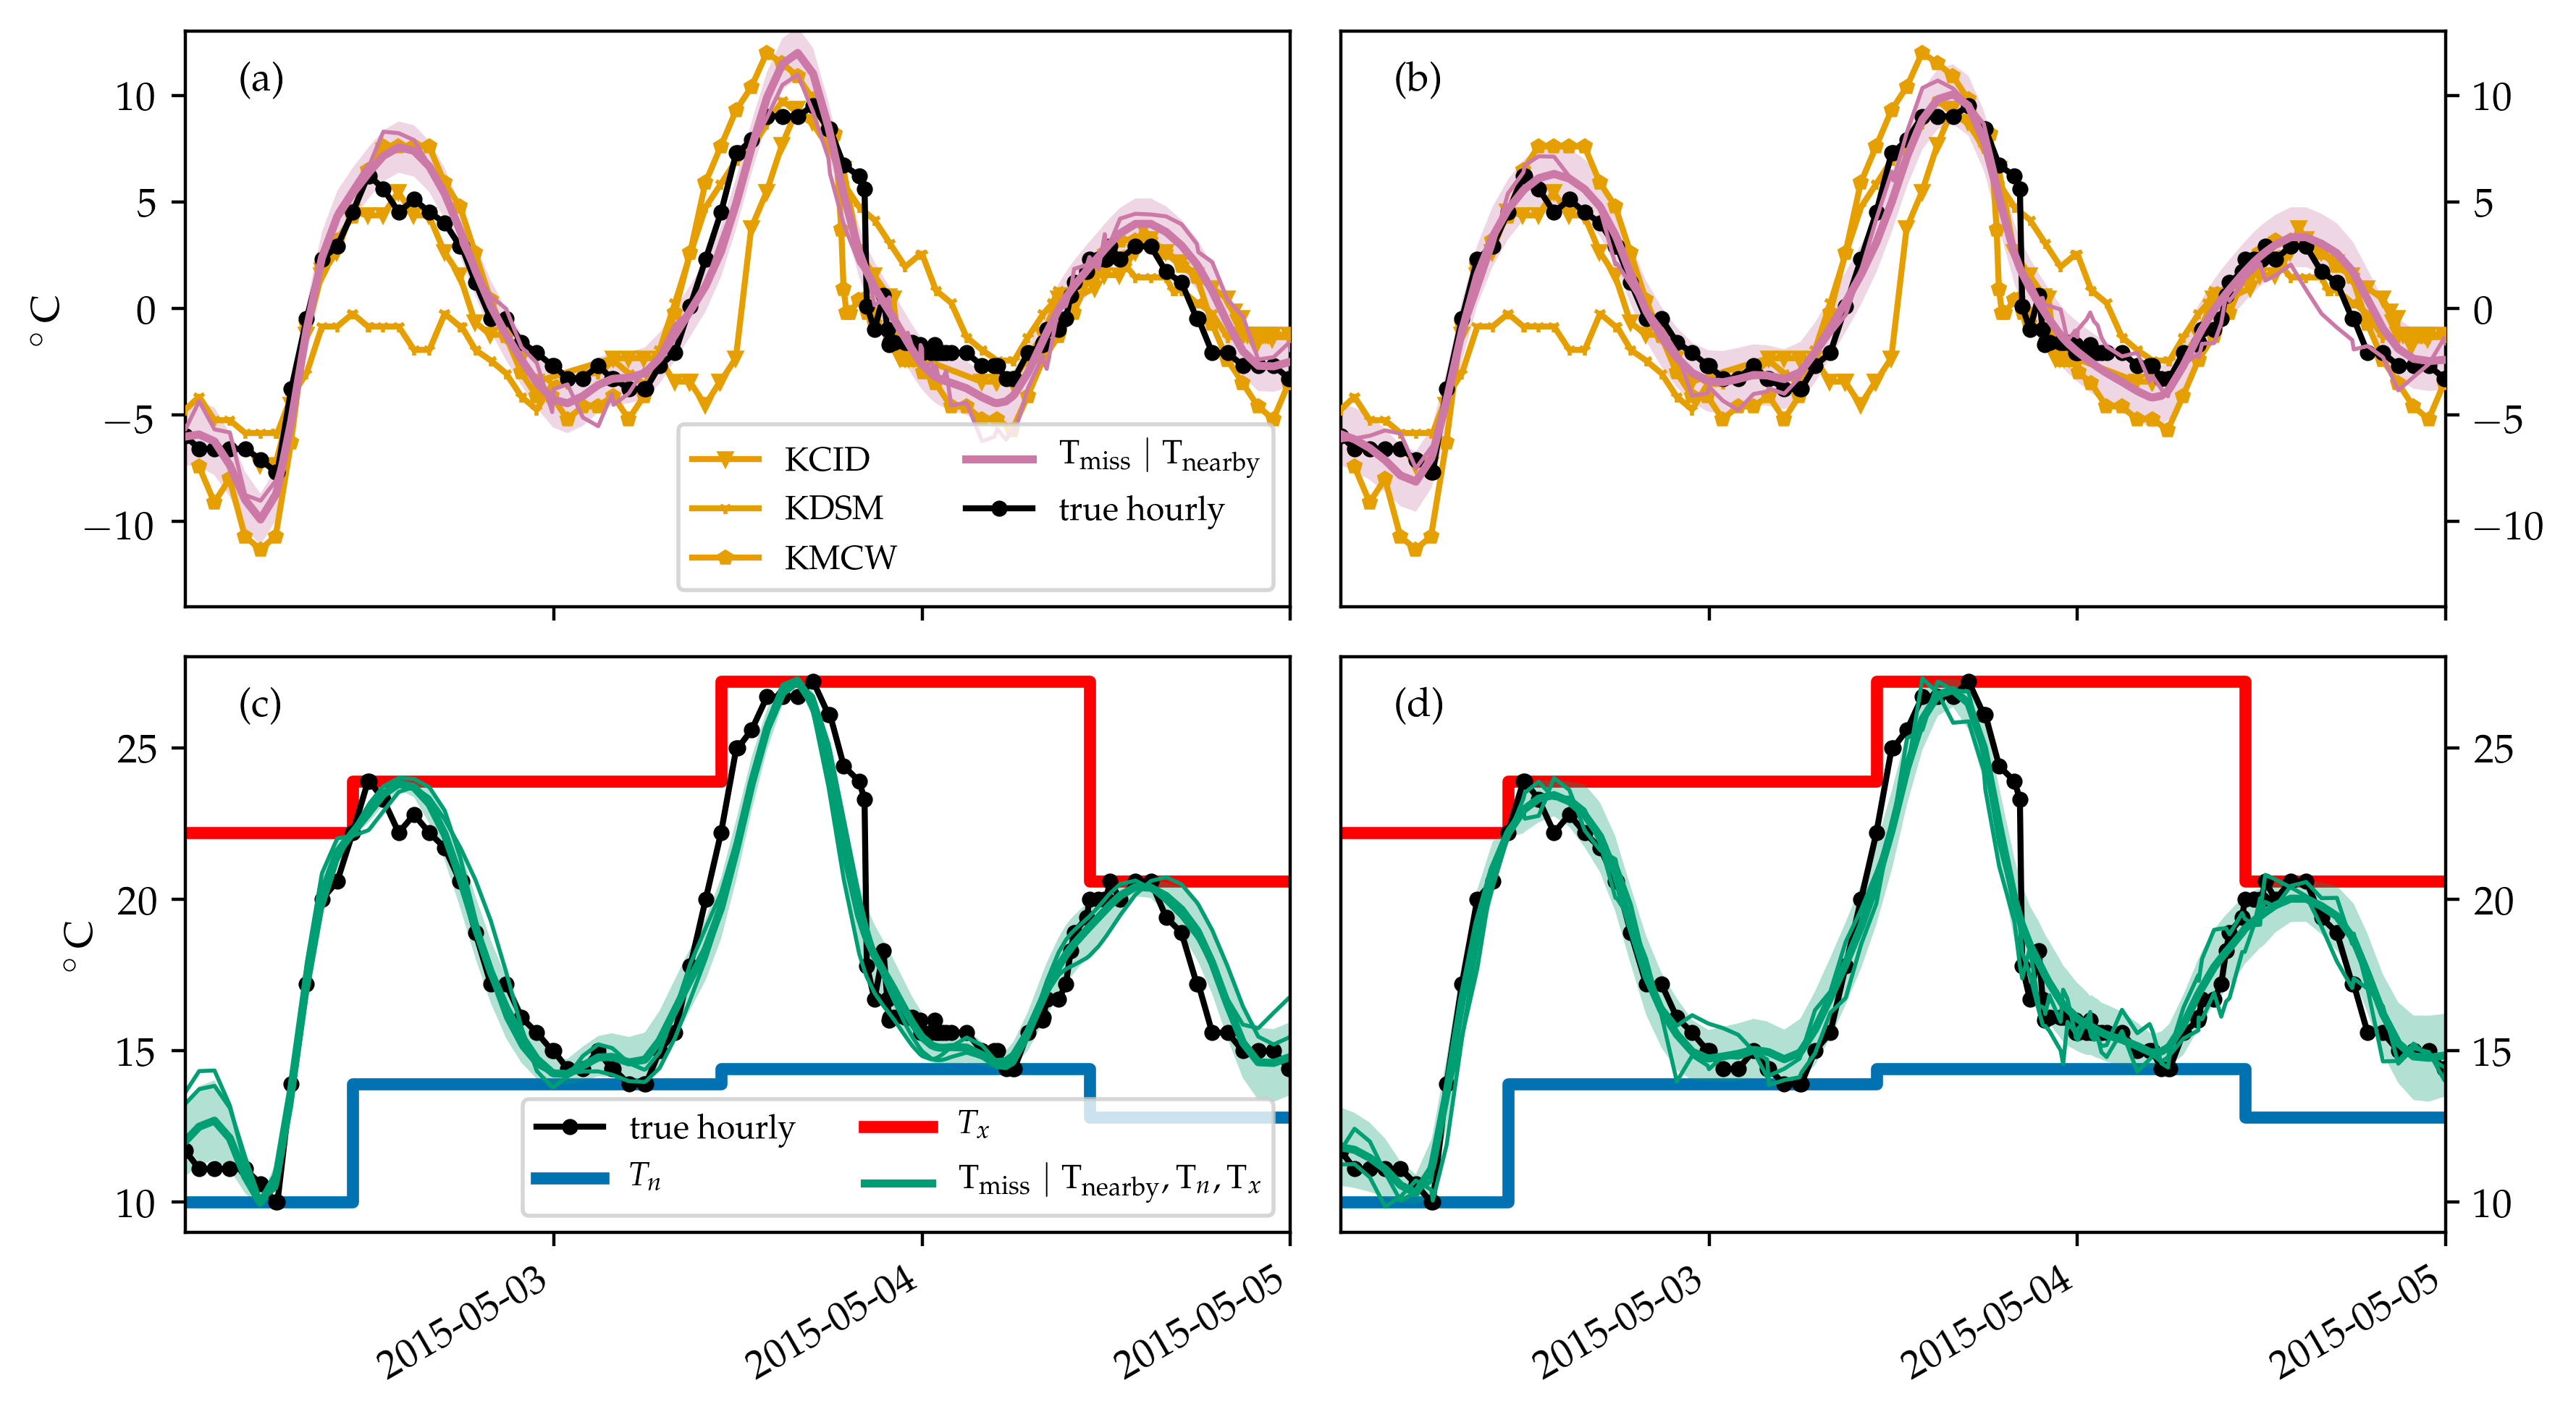

STAN window: Batch.FittingWindow(2015-04-28, 2015-05-07)


In [28]:
xlim1 = DateTime(2015,5,2,6,0,0)
xlim2 = DateTime(2015,5,5,6,0,0)
window_num = 40

plt.subplot(2,2,1)
plot_nearby("SExSE", xlim1, xlim2)
plt.ylim(-14, 13)
leg = plt.legend(loc="lower right", fontsize="small", ncol=2)
leg[:set_zorder](9999)
plt.ylabel(L"${}^{\circ}\,\mathrm{C}$")
title_in_axis("(a)")


plt.subplot(2,2,2)
plot_nearby("simpler", xlim1, xlim2)
title_in_axis("(b)")
plt.ylim(-14, 13)
yaxis_right()


plt.subplot(2,2,3)
plot_stan("SExSE", window_num, xlim1, xlim2, [250, 500])
title_in_axis("(c)")
plt.ylabel(L"${}^{\circ}\,\mathrm{C}$")
leg = plt.legend(loc="lower right", fontsize="small", ncol=2)
# leg[:get_frame]()[:set_alpha](1.0)
# plt.ylim(9,28)

plt.subplot(2,2,4)
plot_stan("simpler", window_num, xlim1, xlim2, [250, 500])
title_in_axis("(d)")
yaxis_right()
# plt.ylim(9,28)
plt.gcf()[:set_size_inches](9.0, 5.0)
plt.gcf()[:tight_layout]()
;

STAN window: Batch.FittingWindow(2015-05-25, 2015-06-03)


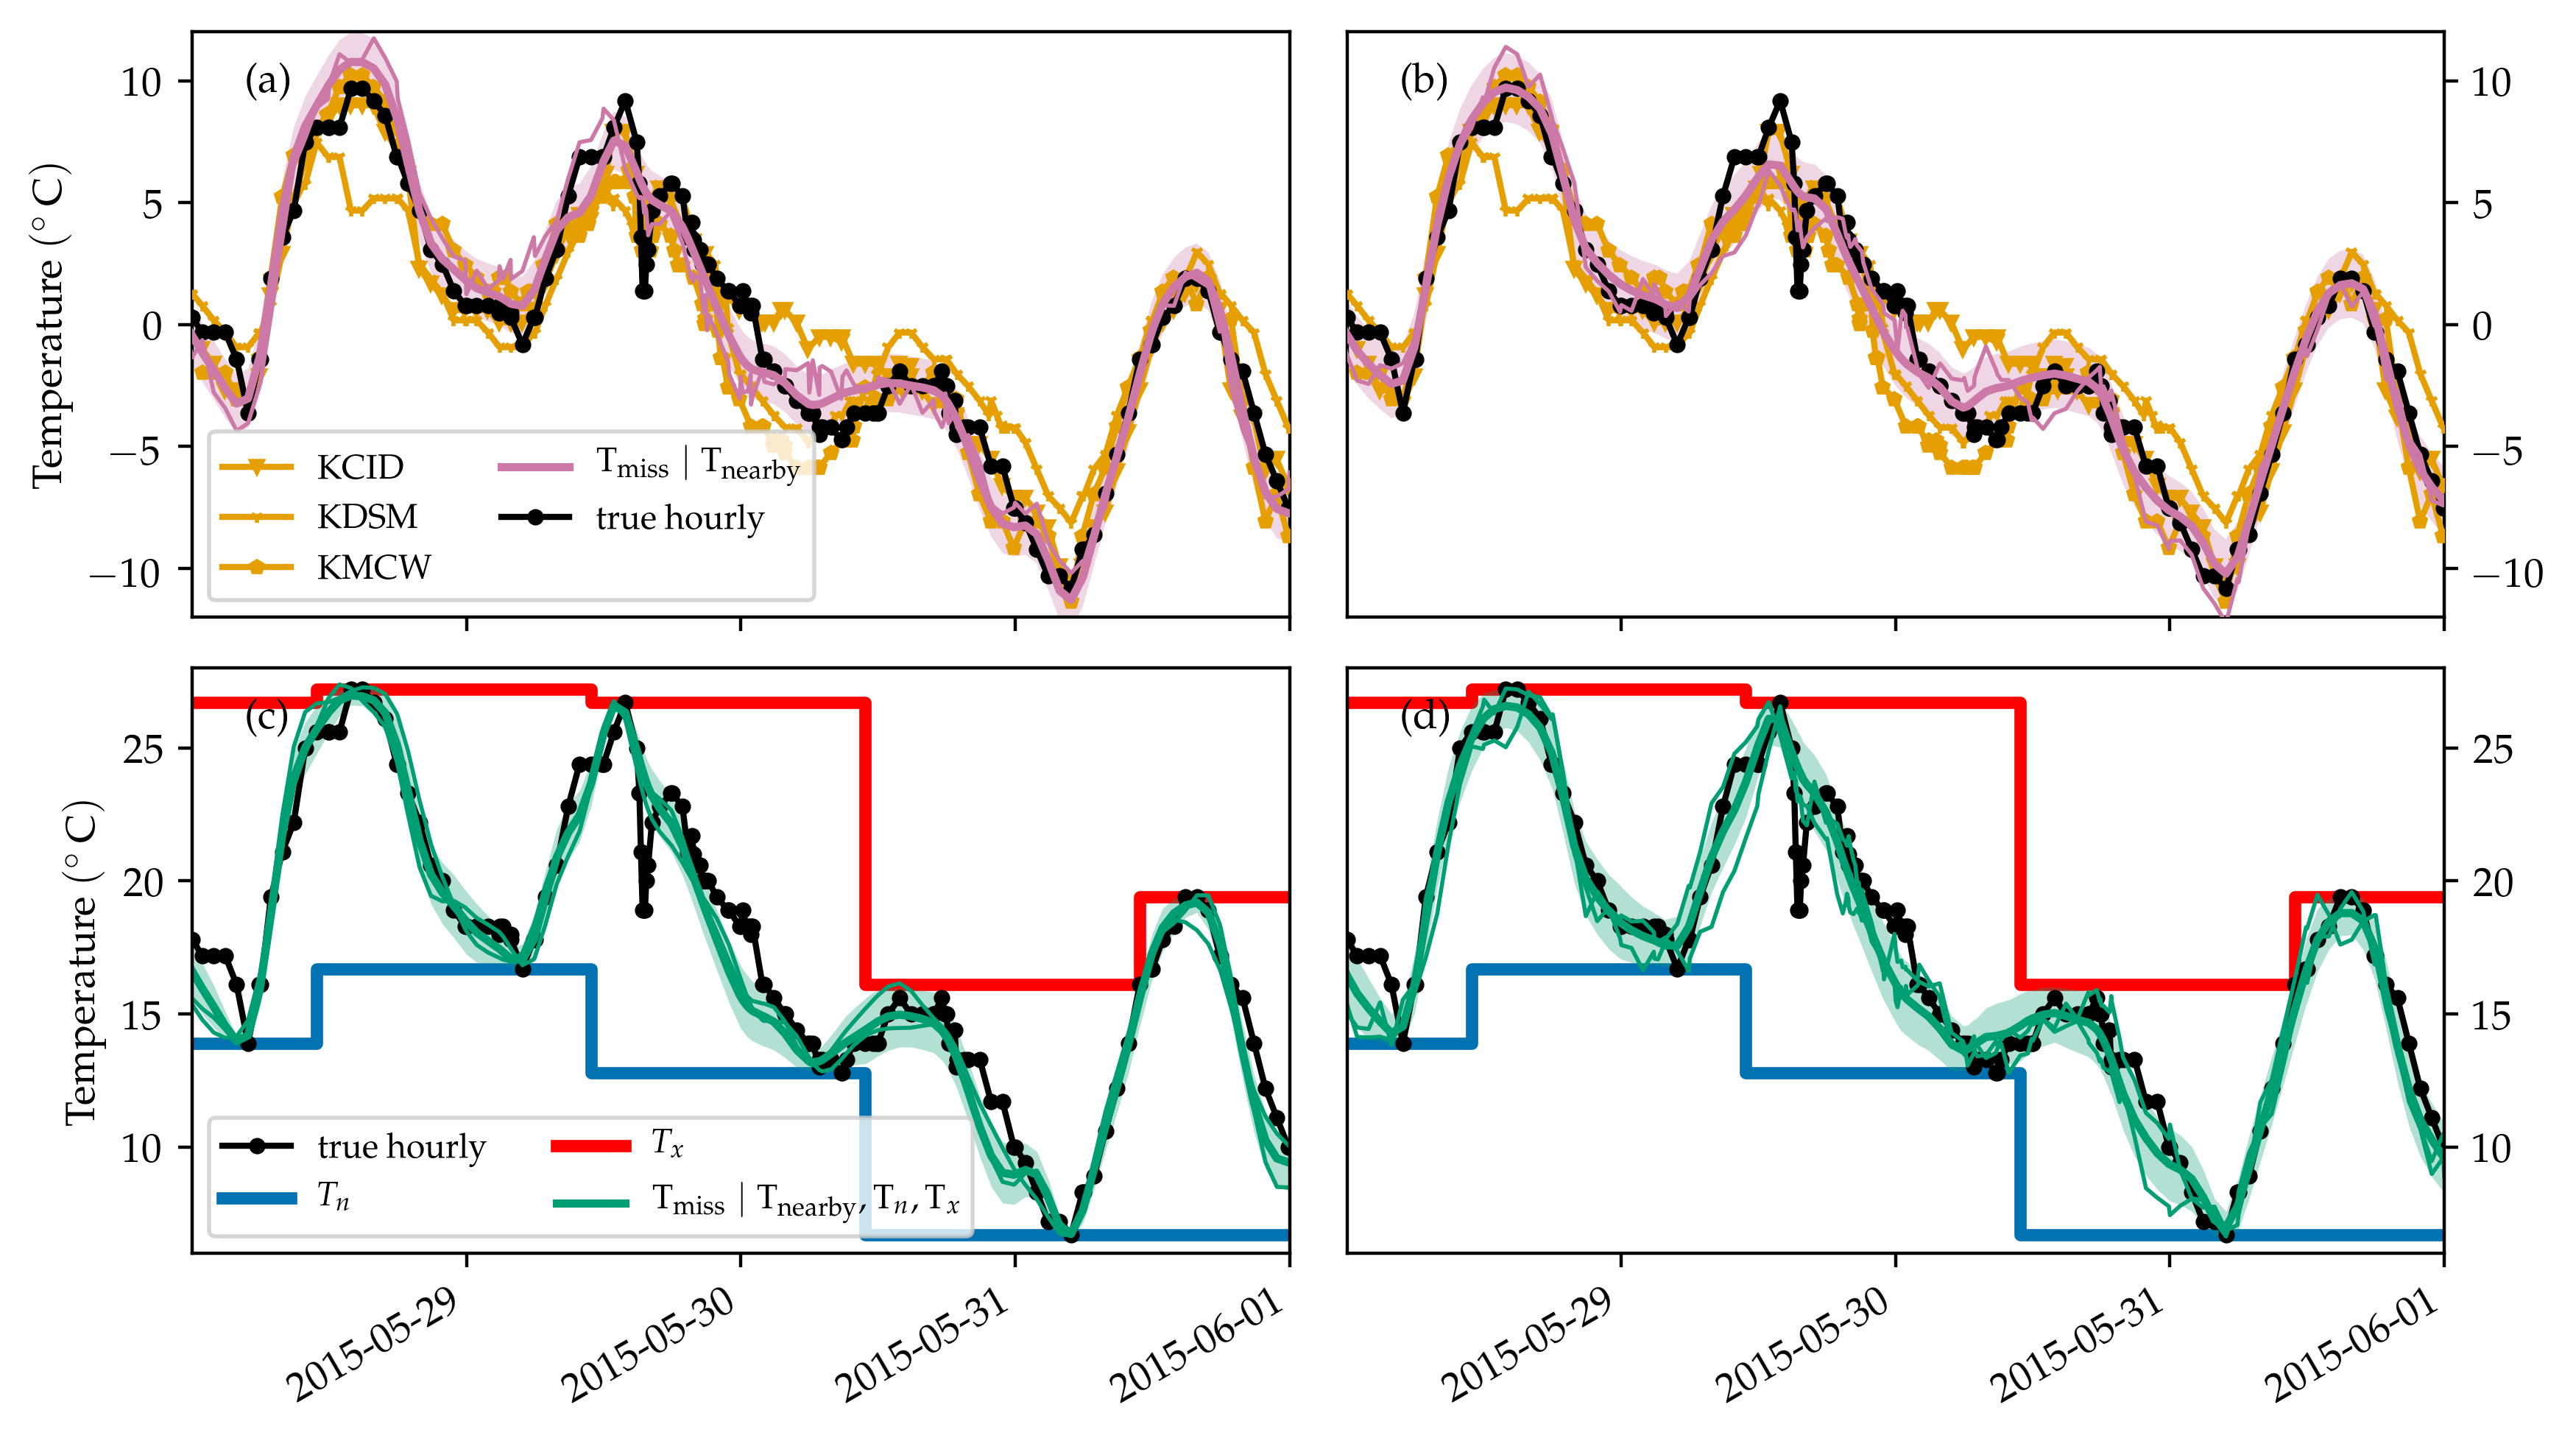

STAN window: Batch.FittingWindow(2015-05-25, 2015-06-03)


In [29]:
xlim1 = DateTime(2015,5,28,6,0,0)
xlim2 = DateTime(2015,6,1,6,0,0)
window_num = 49

plt.subplot(2,2,1)
plot_nearby("SExSE", xlim1, xlim2)
plt.ylim(-12, 12)
leg = plt.legend(loc="lower left", fontsize="small", ncol=2)
leg[:set_zorder](9999)
plt.ylabel(L"Temperature $({}^{\circ}\,\mathrm{C})$")
# plt.ylabel(L"Temperature $({}^{\circ}\,\mathrm{C})$ diff from mean")
# plt.ylabel(L"${}^{\circ}\,\mathrm{C}$")
title_in_axis("(a)")


plt.subplot(2,2,2)
plot_nearby("simpler", xlim1, xlim2)
title_in_axis("(b)")
plt.ylim(-12, 12)
yaxis_right()


plt.subplot(2,2,3)
plot_stan("SExSE", window_num, xlim1, xlim2, [100, 700])
title_in_axis("(c)")
plt.ylabel(L"Temperature $({}^{\circ}\,\mathrm{C})$")
# plt.ylabel(L"${}^{\circ}\,\mathrm{C}$")
leg = plt.legend(loc="lower left", fontsize="small", ncol=2)
leg[:set_zorder](9999)
plt.ylim(6,28)

plt.subplot(2,2,4)
plot_stan("simpler", window_num, xlim1, xlim2, [150, 1000])
title_in_axis("(d)")
yaxis_right()
plt.ylim(6,28)

plt.gcf()[:tight_layout]()
plt.gcf()[:set_size_inches](9.0, 5.0)
plt.savefig("../figures/imputations_2x2.png", bbox_inches="tight")
plt.savefig("../figures/imputations_2x2.pdf", bbox_inches="tight")
;

# May 31st

In [70]:
may31_start, may31_end = extrema(hourly_test[hourly_test[:ts_day] .== Date(2015,5,31), :ts])

(2015-05-30T17:34:00, 2015-05-31T16:54:00)

In [108]:
GPmodel = "simpler"

"simpler"

In [109]:
stan_fw = Batch.get_window(49)
hr_measure = Hour(17)
w49_chains, w49_ts = Batch.get_chains_and_ts(stan_fw, GPmodel, test_usaf)
w49_temp_impute = Batch.get_temperatures_reparam(w49_chains)
w49_stacked = vcat((w49_temp_impute[:,:,ichain] for ichain in 1:size(w49_temp_impute,3))...)
may31_ts = w49_ts[ may31_start .<= w49_ts .<= may31_end]
nsamples = size(w49_stacked, 1)

4000

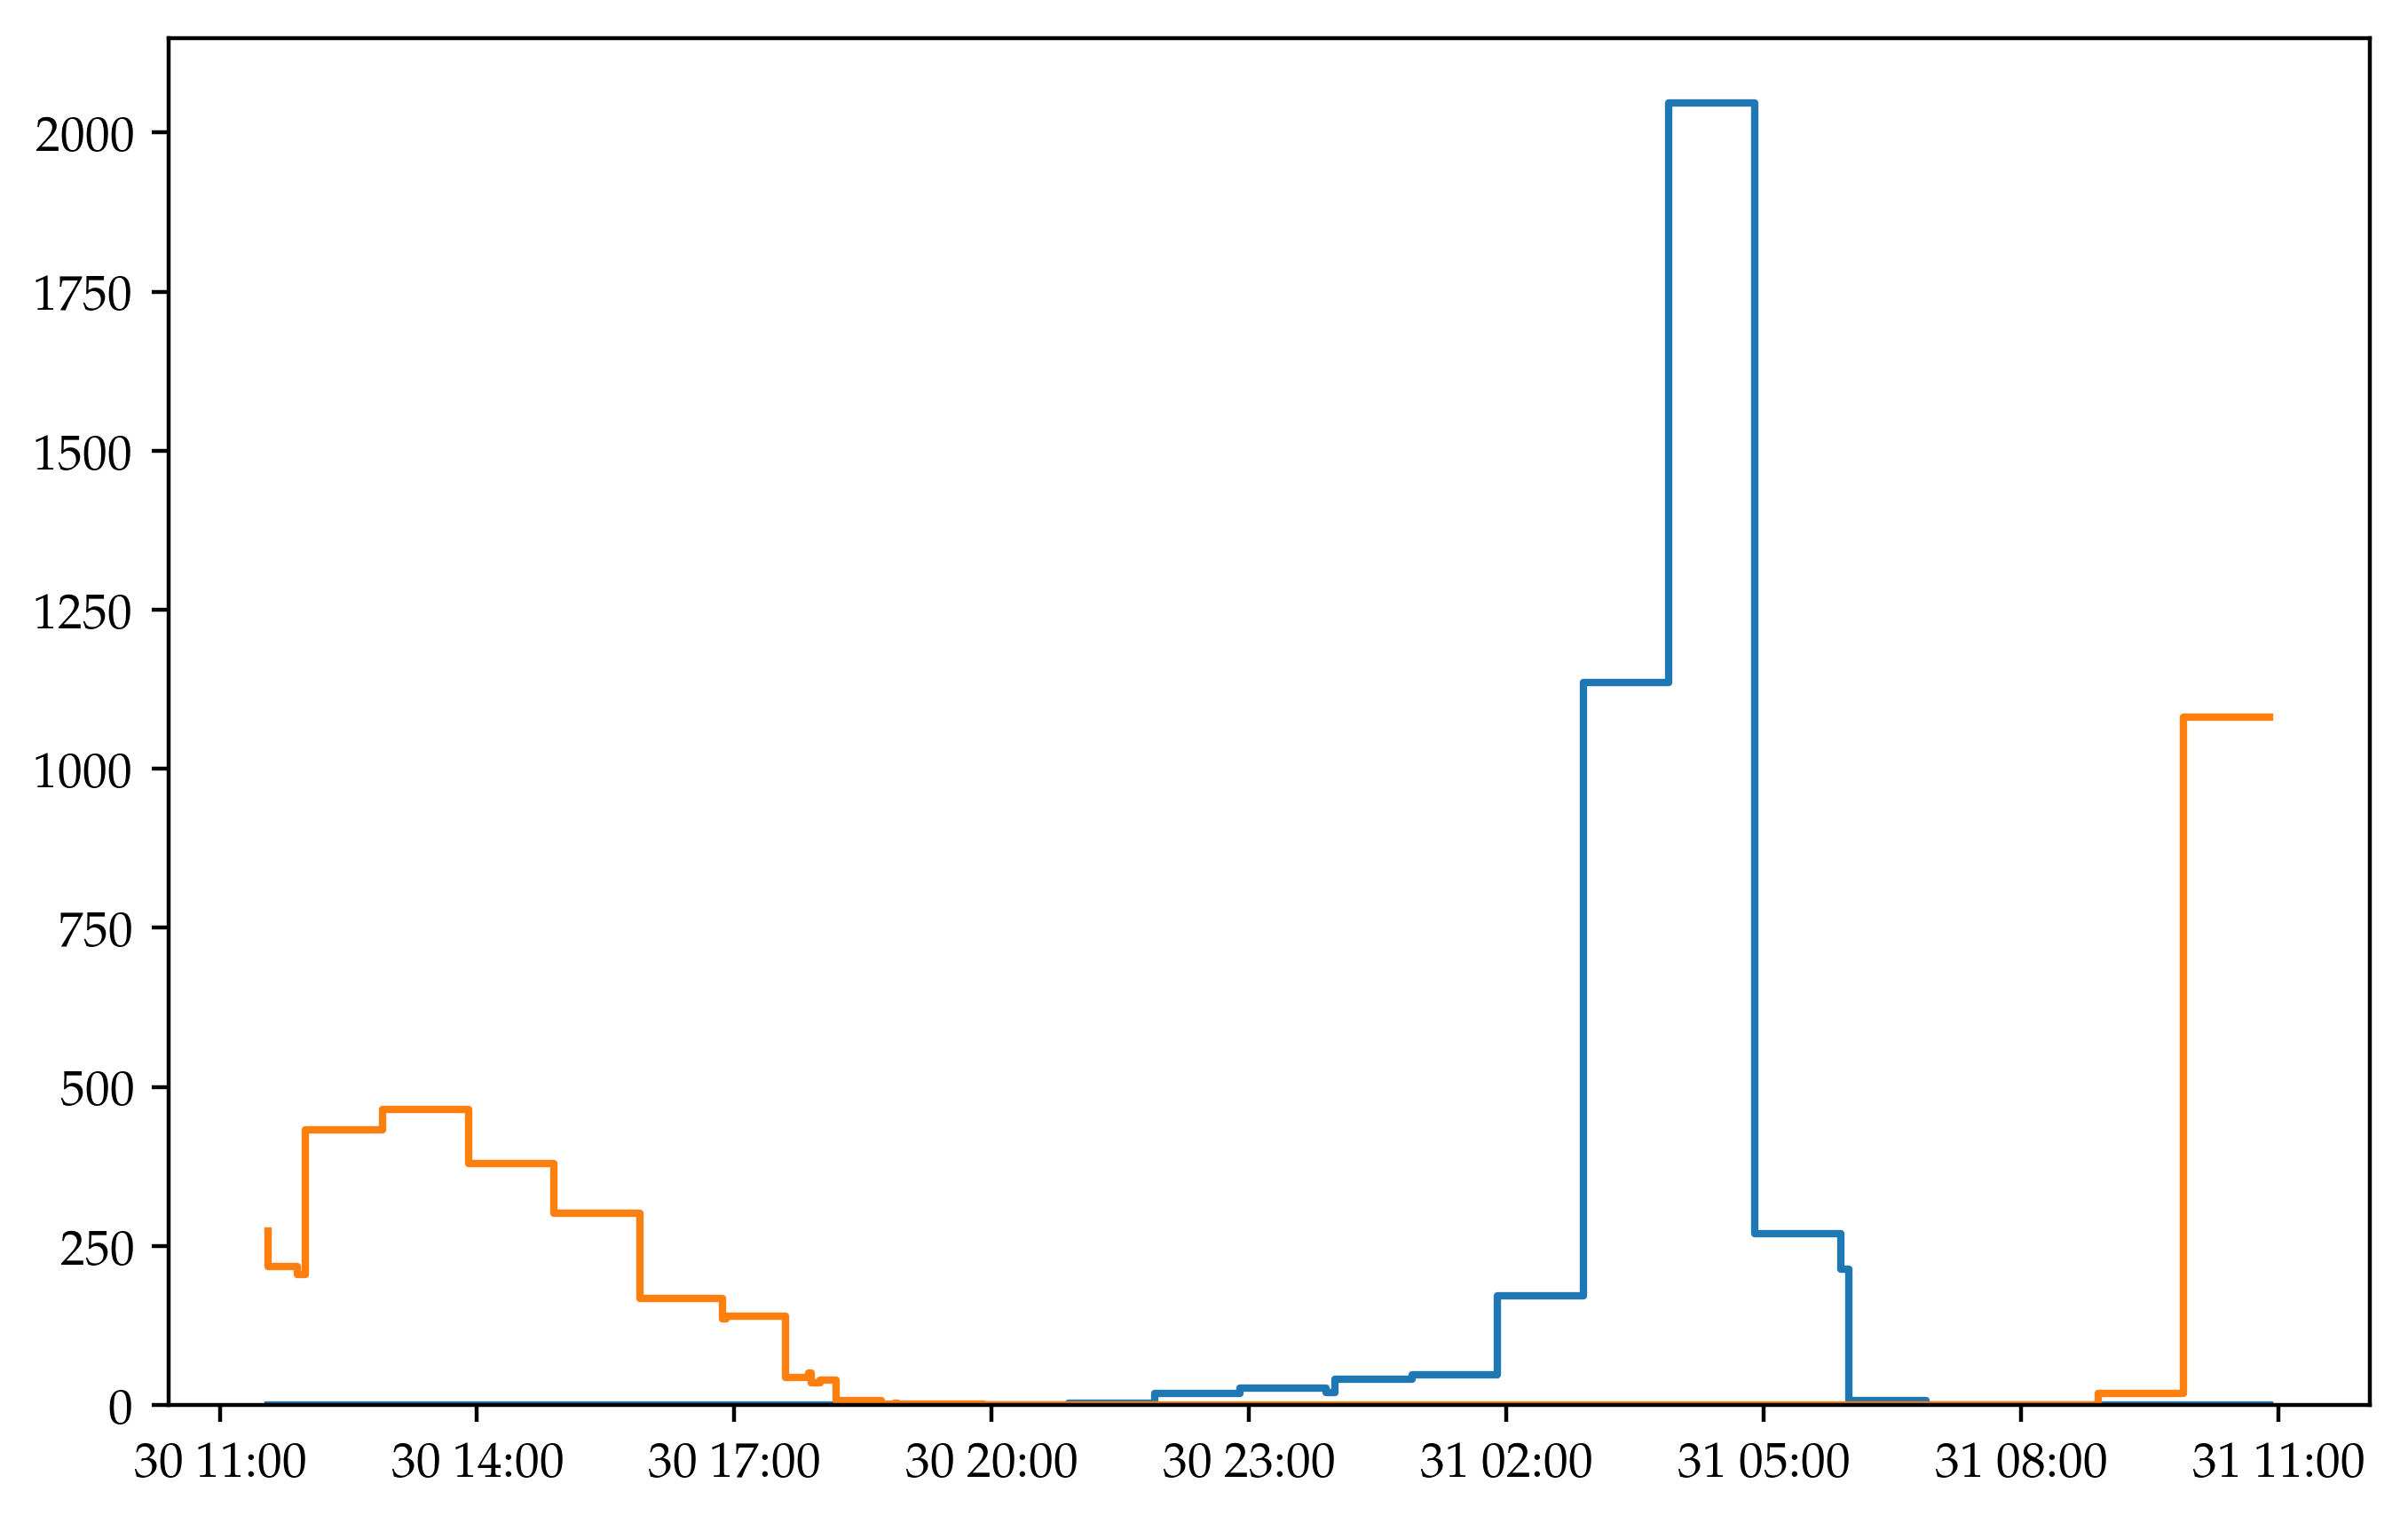

(0, 2148.3)

In [110]:
may31_temp_impute = w49_stacked[:, may31_start .<= w49_ts .<= may31_end]
may31_indmin = [indmin(may31_temp_impute[isample, :]) for isample in 1:nsamples]
may31_indmax = [indmax(may31_temp_impute[isample, :]) for isample in 1:nsamples]
plt.step(iowa_time(may31_ts), StatsBase.counts(may31_indmin, 1:length(may31_ts)))
plt.step(iowa_time(may31_ts), StatsBase.counts(may31_indmax, 1:length(may31_ts)))
plt.gca()[:xaxis][:set_major_formatter](plt.matplotlib[:dates][:DateFormatter]("%d %H:%M"))
plt.ylim(0)

In [118]:
may31_tmax = iowa_time(may31_ts)[may31_indmax]
mean(may31_tmax .< DateTime(2015, 5, 30, 20)), mean(may31_tmax .> DateTime(2015, 5, 31, 8))

(0.72525, 0.27475)

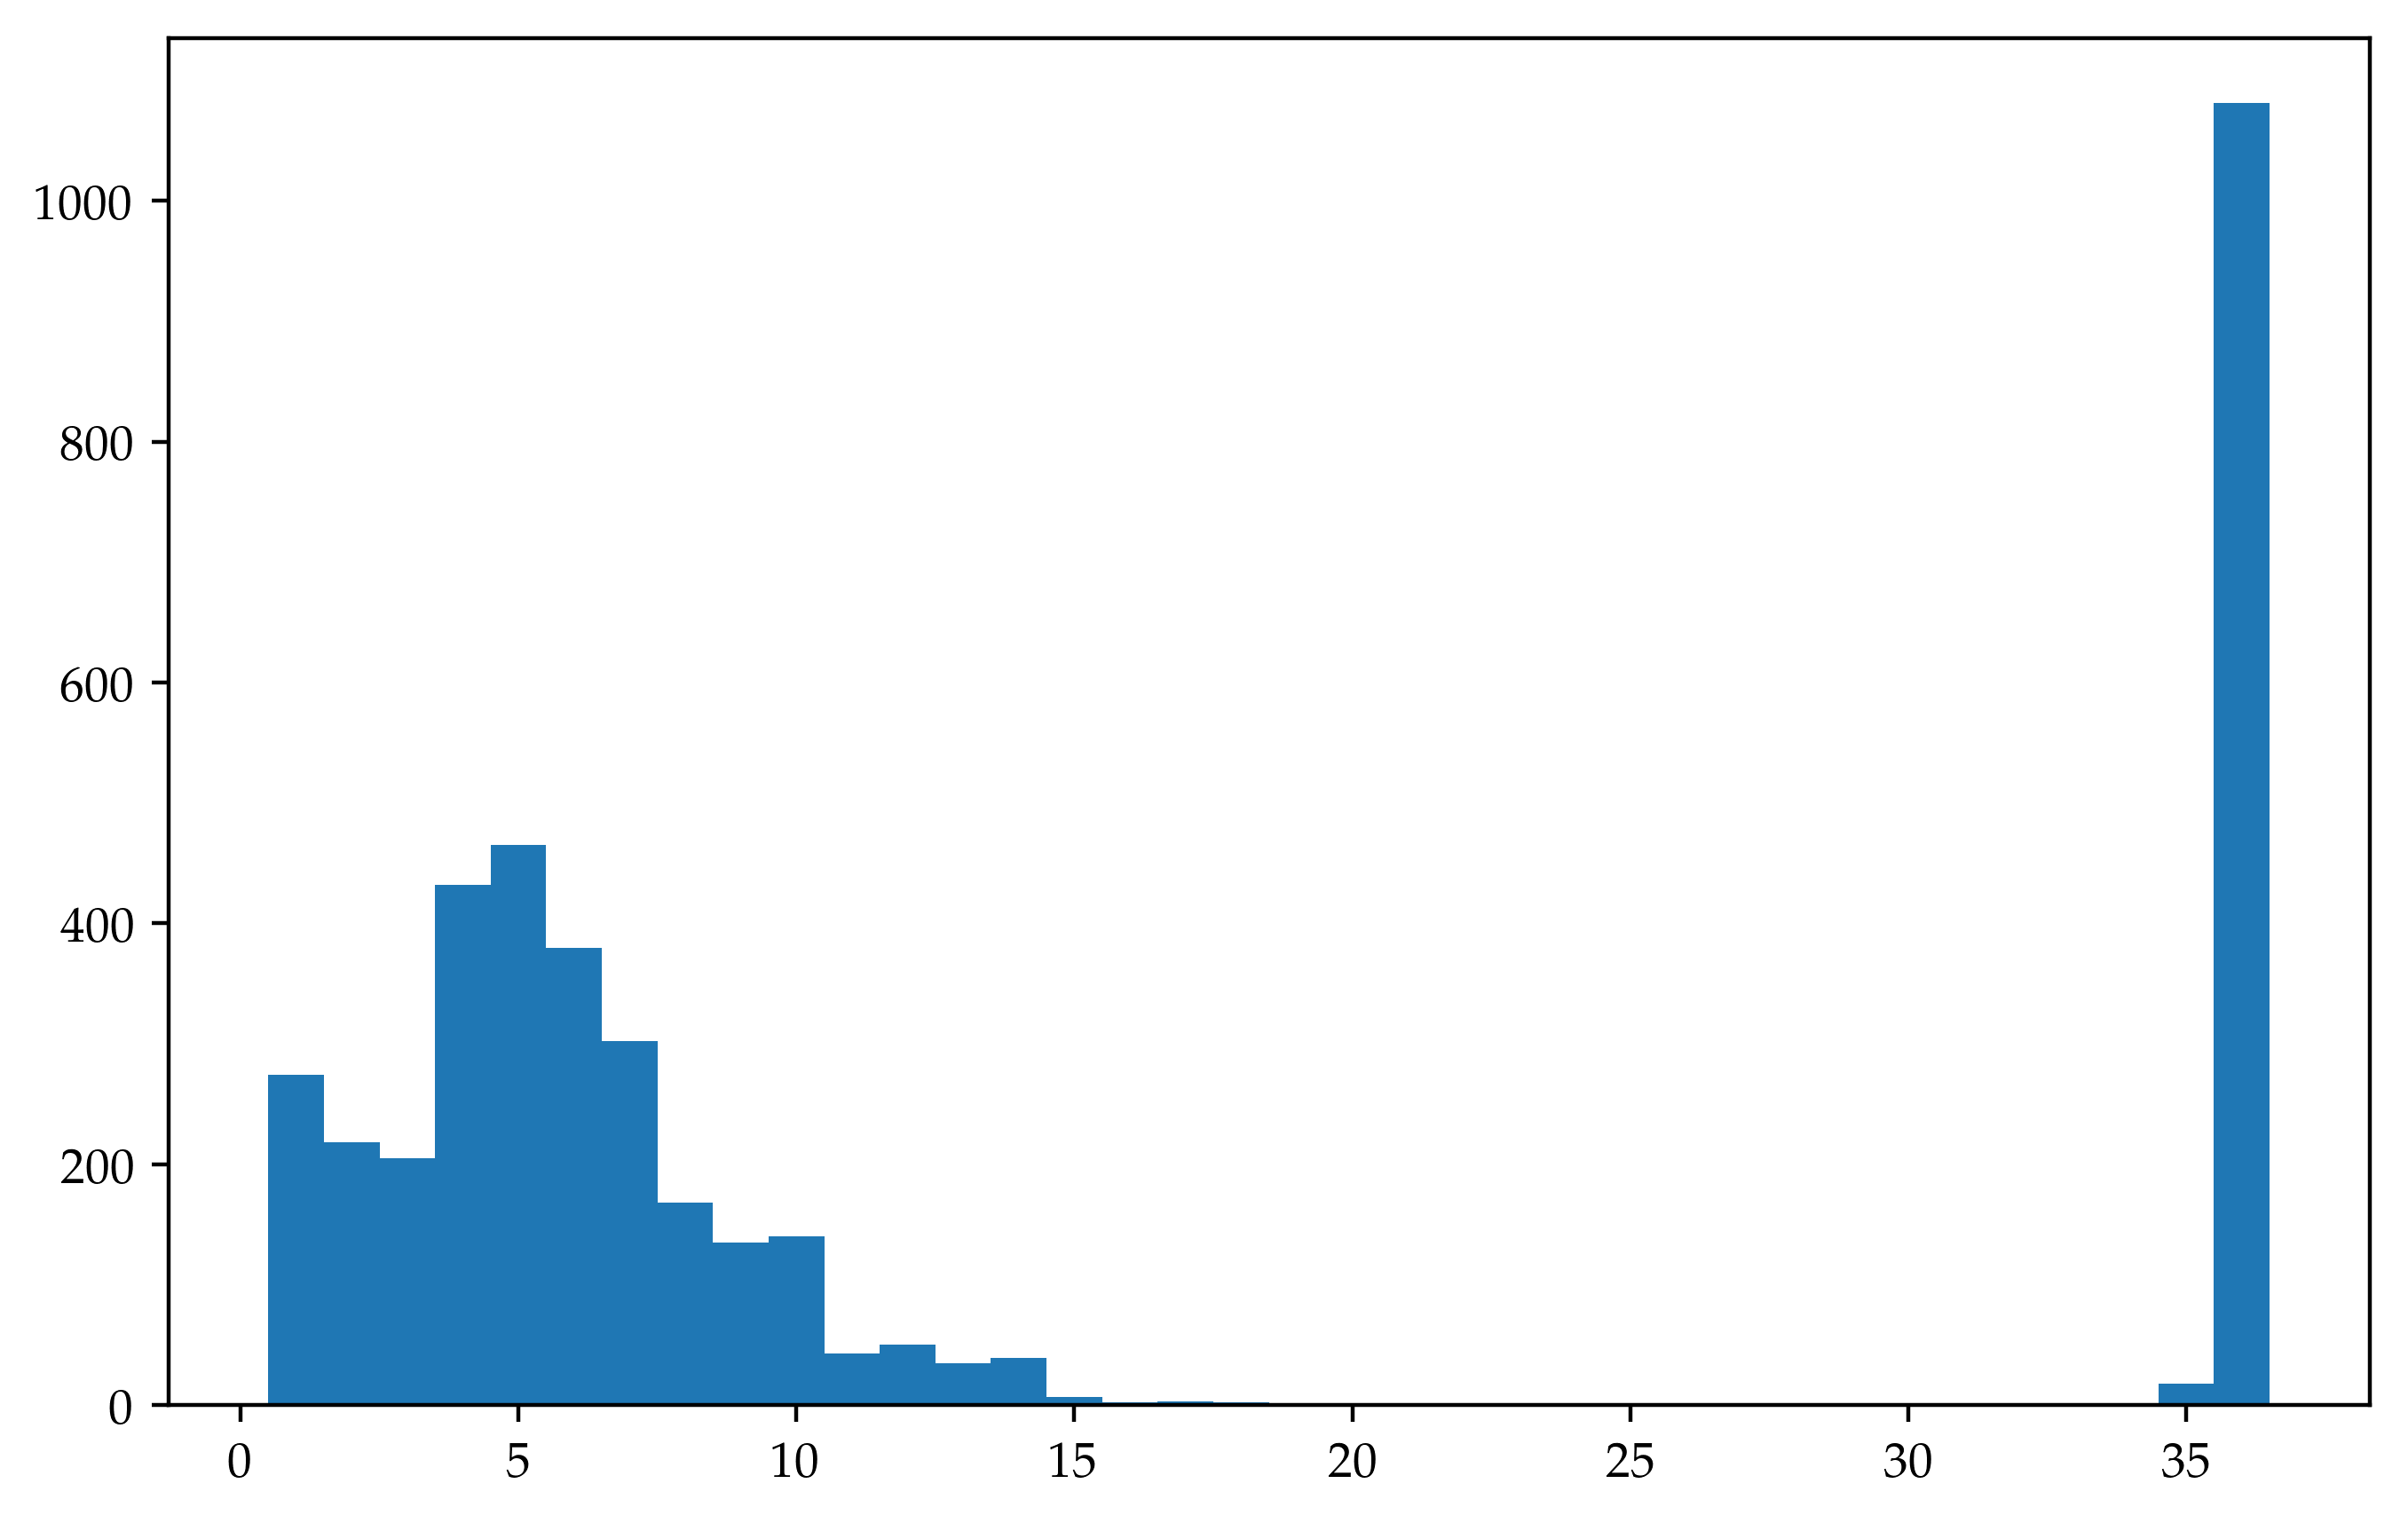

([274.0, 218.0, 205.0, 432.0, 465.0, 380.0, 302.0, 168.0, 135.0, 140.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 1081.0], [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5  …  27.5, 28.5, 29.5, 30.5, 31.5, 32.5, 33.5, 34.5, 35.5, 36.5], PyCall.PyObject[PyObject <matplotlib.patches.Rectangle object at 0x132f9d128>, PyObject <matplotlib.patches.Rectangle object at 0x132f93ef0>, PyObject <matplotlib.patches.Rectangle object at 0x132f9d710>, PyObject <matplotlib.patches.Rectangle object at 0x132f9da90>, PyObject <matplotlib.patches.Rectangle object at 0x132f9de10>, PyObject <matplotlib.patches.Rectangle object at 0x132fa61d0>, PyObject <matplotlib.patches.Rectangle object at 0x132fa6550>, PyObject <matplotlib.patches.Rectangle object at 0x132fa68d0>, PyObject <matplotlib.patches.Rectangle object at 0x132fa6c50>, PyObject <matplotlib.patches.Rectangle object at 0x132fa6fd0>  …  PyObject <matplotlib.patches.Rectangle object at 0x1438e8c50>, PyObject <matplotlib.patches.Rectangle obje

In [112]:
plt.plt[:hist](may31_indmax, bins=0.5:1:length(may31_ts)+1)

# Aggregating  imputation MSE over all windows

In [119]:
all_impt_diagn = Dict{String, Vector{Batch.ImputationDiagnostic}}()

Dict{String,Array{Batch.ImputationDiagnostic,1}} with 0 entries

In [120]:
function all_imput_mse(GPmodel)
    diagn_vec = Batch.ImputationDiagnostic[]
    hr_measure = Hour(17)
    for window_num in 1:150
        print(window_num,", ")
        # get the start and end datetime for this stan window
        stan_fw = Batch.get_window(window_num)
        # get the central 3 days of the window
        center_fw = Batch.window_center(stan_fw, Batch.stan_increment)
        # load the MCMC output from disk
        local chains
        local ts
        try
            chains, ts = Batch.get_chains_and_ts(stan_fw, GPmodel, test_usaf)
        catch
            break
        end
        # extract temepratures from MCMC
        temp_impute = Batch.get_temperatures_reparam(chains)
        # subset of test dataframe coinciding with the STAN window
        test_stan_fw = Batch.get_test_fw(test_trimmed, stan_fw, hr_measure)
        # subset of test dataframe coinciding with the center of the  STAN window
        arg_center_fw = Batch.arg_test_fw(test_stan_fw, center_fw, hr_measure)
        test_center_fw = Batch.get_test_fw(test_stan_fw, center_fw, hr_measure)
        # extract MCMC imputed temperatures for center of the STAN window
        temp_impute_center = temp_impute[:,arg_center_fw,:]
        # generate diagnostic
        diagn = Batch.ImputationDiagnostic(temp_impute_center, test_center_fw)
        push!(diagn_vec, diagn)
    end
    return diagn_vec
end

all_imput_mse (generic function with 1 method)

In [121]:
GPmodel = "SExSE"
all_impt_diagn[GPmodel] = all_imput_mse(GPmodel)
@printf("E(var(predicted mean - predictive draw))=%.5f\n", Batch.EVarError(sum(all_impt_diagn[GPmodel])))
@printf("MSE(truth - predicted mean)=             %.5f\n", Batch.mse(sum(all_impt_diagn[GPmodel])))

1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, E(var(predicted mean - predictive draw))=0.44239
MSE(truth - predicted mean)=             1.11551


In [122]:
GPmodel = "simpler"
all_impt_diagn[GPmodel] = all_imput_mse(GPmodel)
print("\n")
@printf("E(var(predicted mean - predictive draw))=%.5f\n", Batch.EVarError(sum(all_impt_diagn[GPmodel])))
@printf("MSE(truth - predicted mean)=             %.5f\n", Batch.mse(sum(all_impt_diagn[GPmodel])))

1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 
E(var(predicted mean - predictive draw))=0.81225
MSE(truth - predicted mean)=             1.03690


In [123]:
GPmodel = "diurnal"
all_impt_diagn[GPmodel] = all_imput_mse(GPmodel)
print("\n")
@printf("E(var(predicted mean - predictive draw))=%.5f\n", Batch.EVarError(sum(all_impt_diagn[GPmodel])))
@printf("MSE(truth - predicted mean)=             %.5f\n", Batch.mse(sum(all_impt_diagn[GPmodel])))

1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 
E(var(predicted mean - predictive draw))=0.68952
MSE(truth - predicted mean)=             1.12229


In [125]:
GPmodel = "free_var"
all_impt_diagn[GPmodel] = all_imput_mse(GPmodel)
print("\n")
@printf("E(var(predicted mean - predictive draw))=%.5f\n", Batch.EVarError(sum(all_impt_diagn[GPmodel])))
@printf("MSE(truth - predicted mean)=             %.5f\n", Batch.mse(sum(all_impt_diagn[GPmodel])))

1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 
E(var(predicted mean - predictive draw))=0.89740
MSE(truth - predicted mean)=             2.49342


In [126]:
GPmodel = "sumprod"
all_impt_diagn[GPmodel] = all_imput_mse(GPmodel)
print("\n")
@printf("E(var(predicted mean - predictive draw))=%.5f\n", Batch.EVarError(sum(all_impt_diagn[GPmodel])))
@printf("MSE(truth - predicted mean)=             %.5f\n", Batch.mse(sum(all_impt_diagn[GPmodel])))

1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 
E(var(predicted mean - predictive draw))=0.95070
MSE(truth - predicted mean)=             2.44979


In [146]:
for GPmodel in ["SExSE", "diurnal", "simpler"]
    diagns = all_impt_diagn[GPmodel]
    @printf("model: %s\n", GPmodel)
    @printf("empirical MSE = %.3f\n", Batch.mse(sum(diagns)))
    @printf("estimated MSE = %.3f\n", Batch.EVarError(sum(diagns)))
    print("=============================\n")
end

model: SExSE
empirical MSE = 1.116
estimated MSE = 0.442
model: diurnal
empirical MSE = 1.122
estimated MSE = 0.690
model: simpler
empirical MSE = 1.037
estimated MSE = 0.812


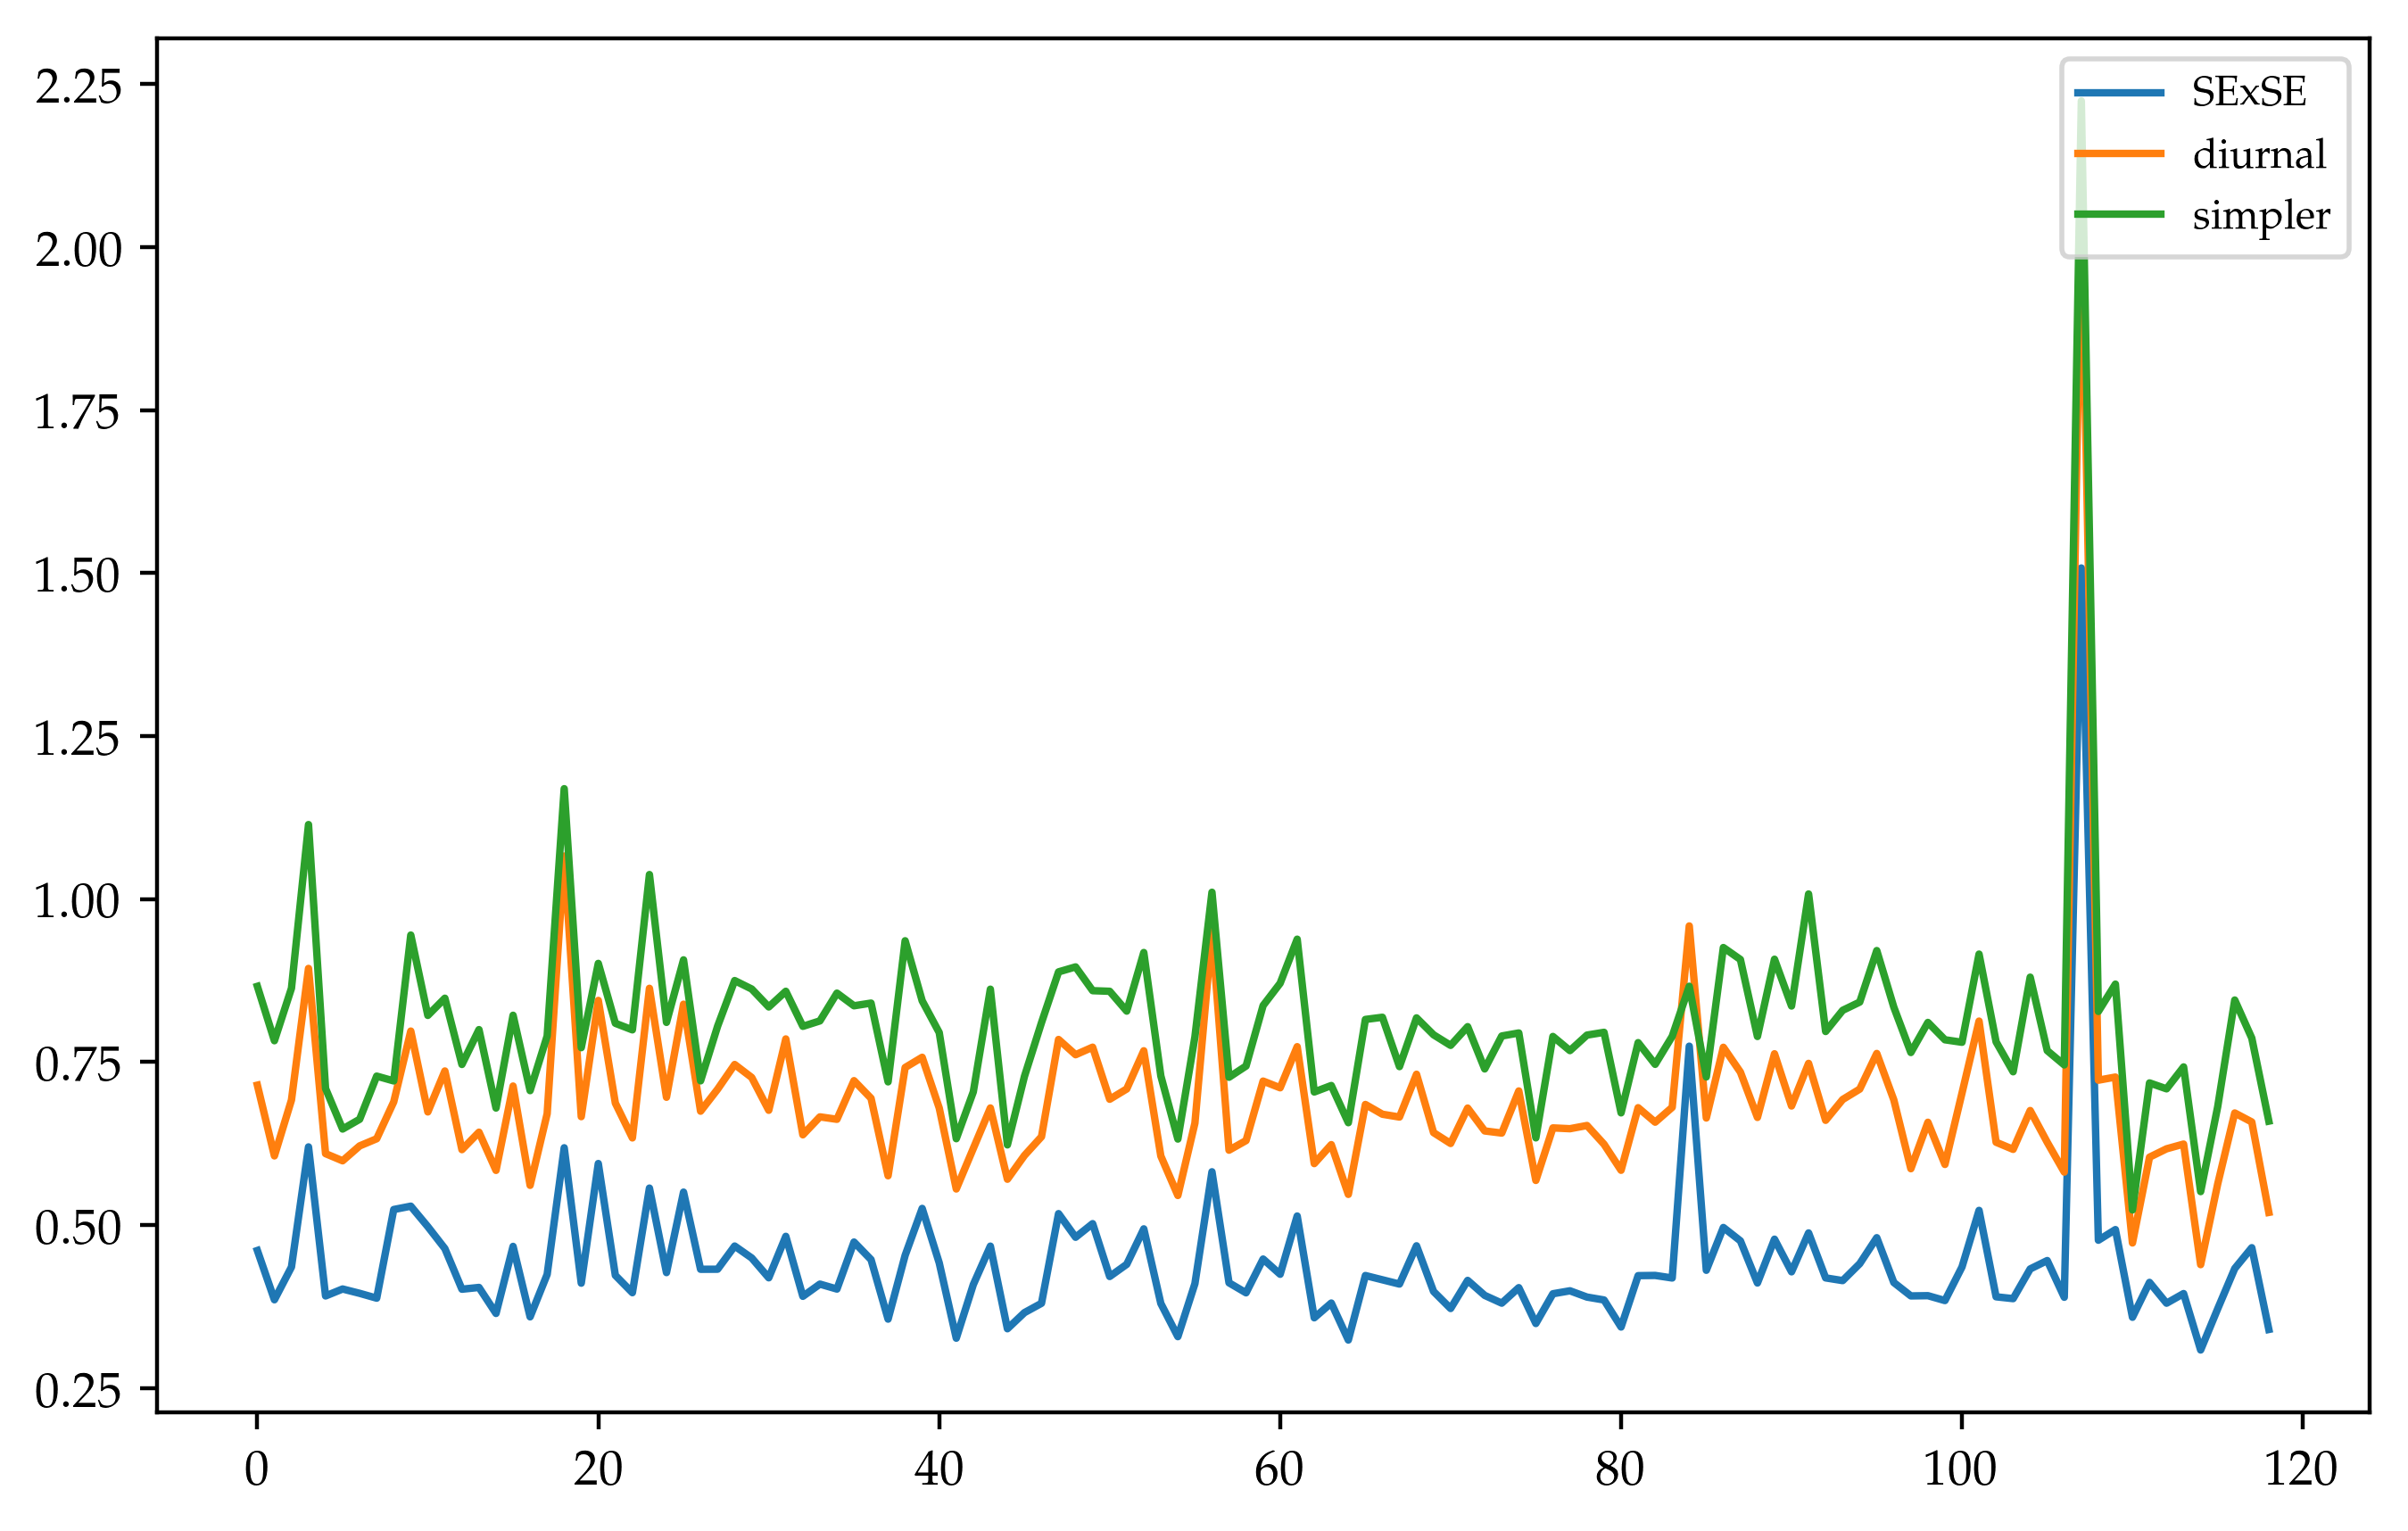

PyObject <matplotlib.legend.Legend object at 0x14346a128>

In [147]:
for GPmodel in ["SExSE", "diurnal", "simpler"]
    diagns = all_impt_diagn[GPmodel]
    plt.plot([Batch.EVarError(d) for d in diagns], label=GPmodel)
end
plt.legend(loc="upper right", fontsize="small")

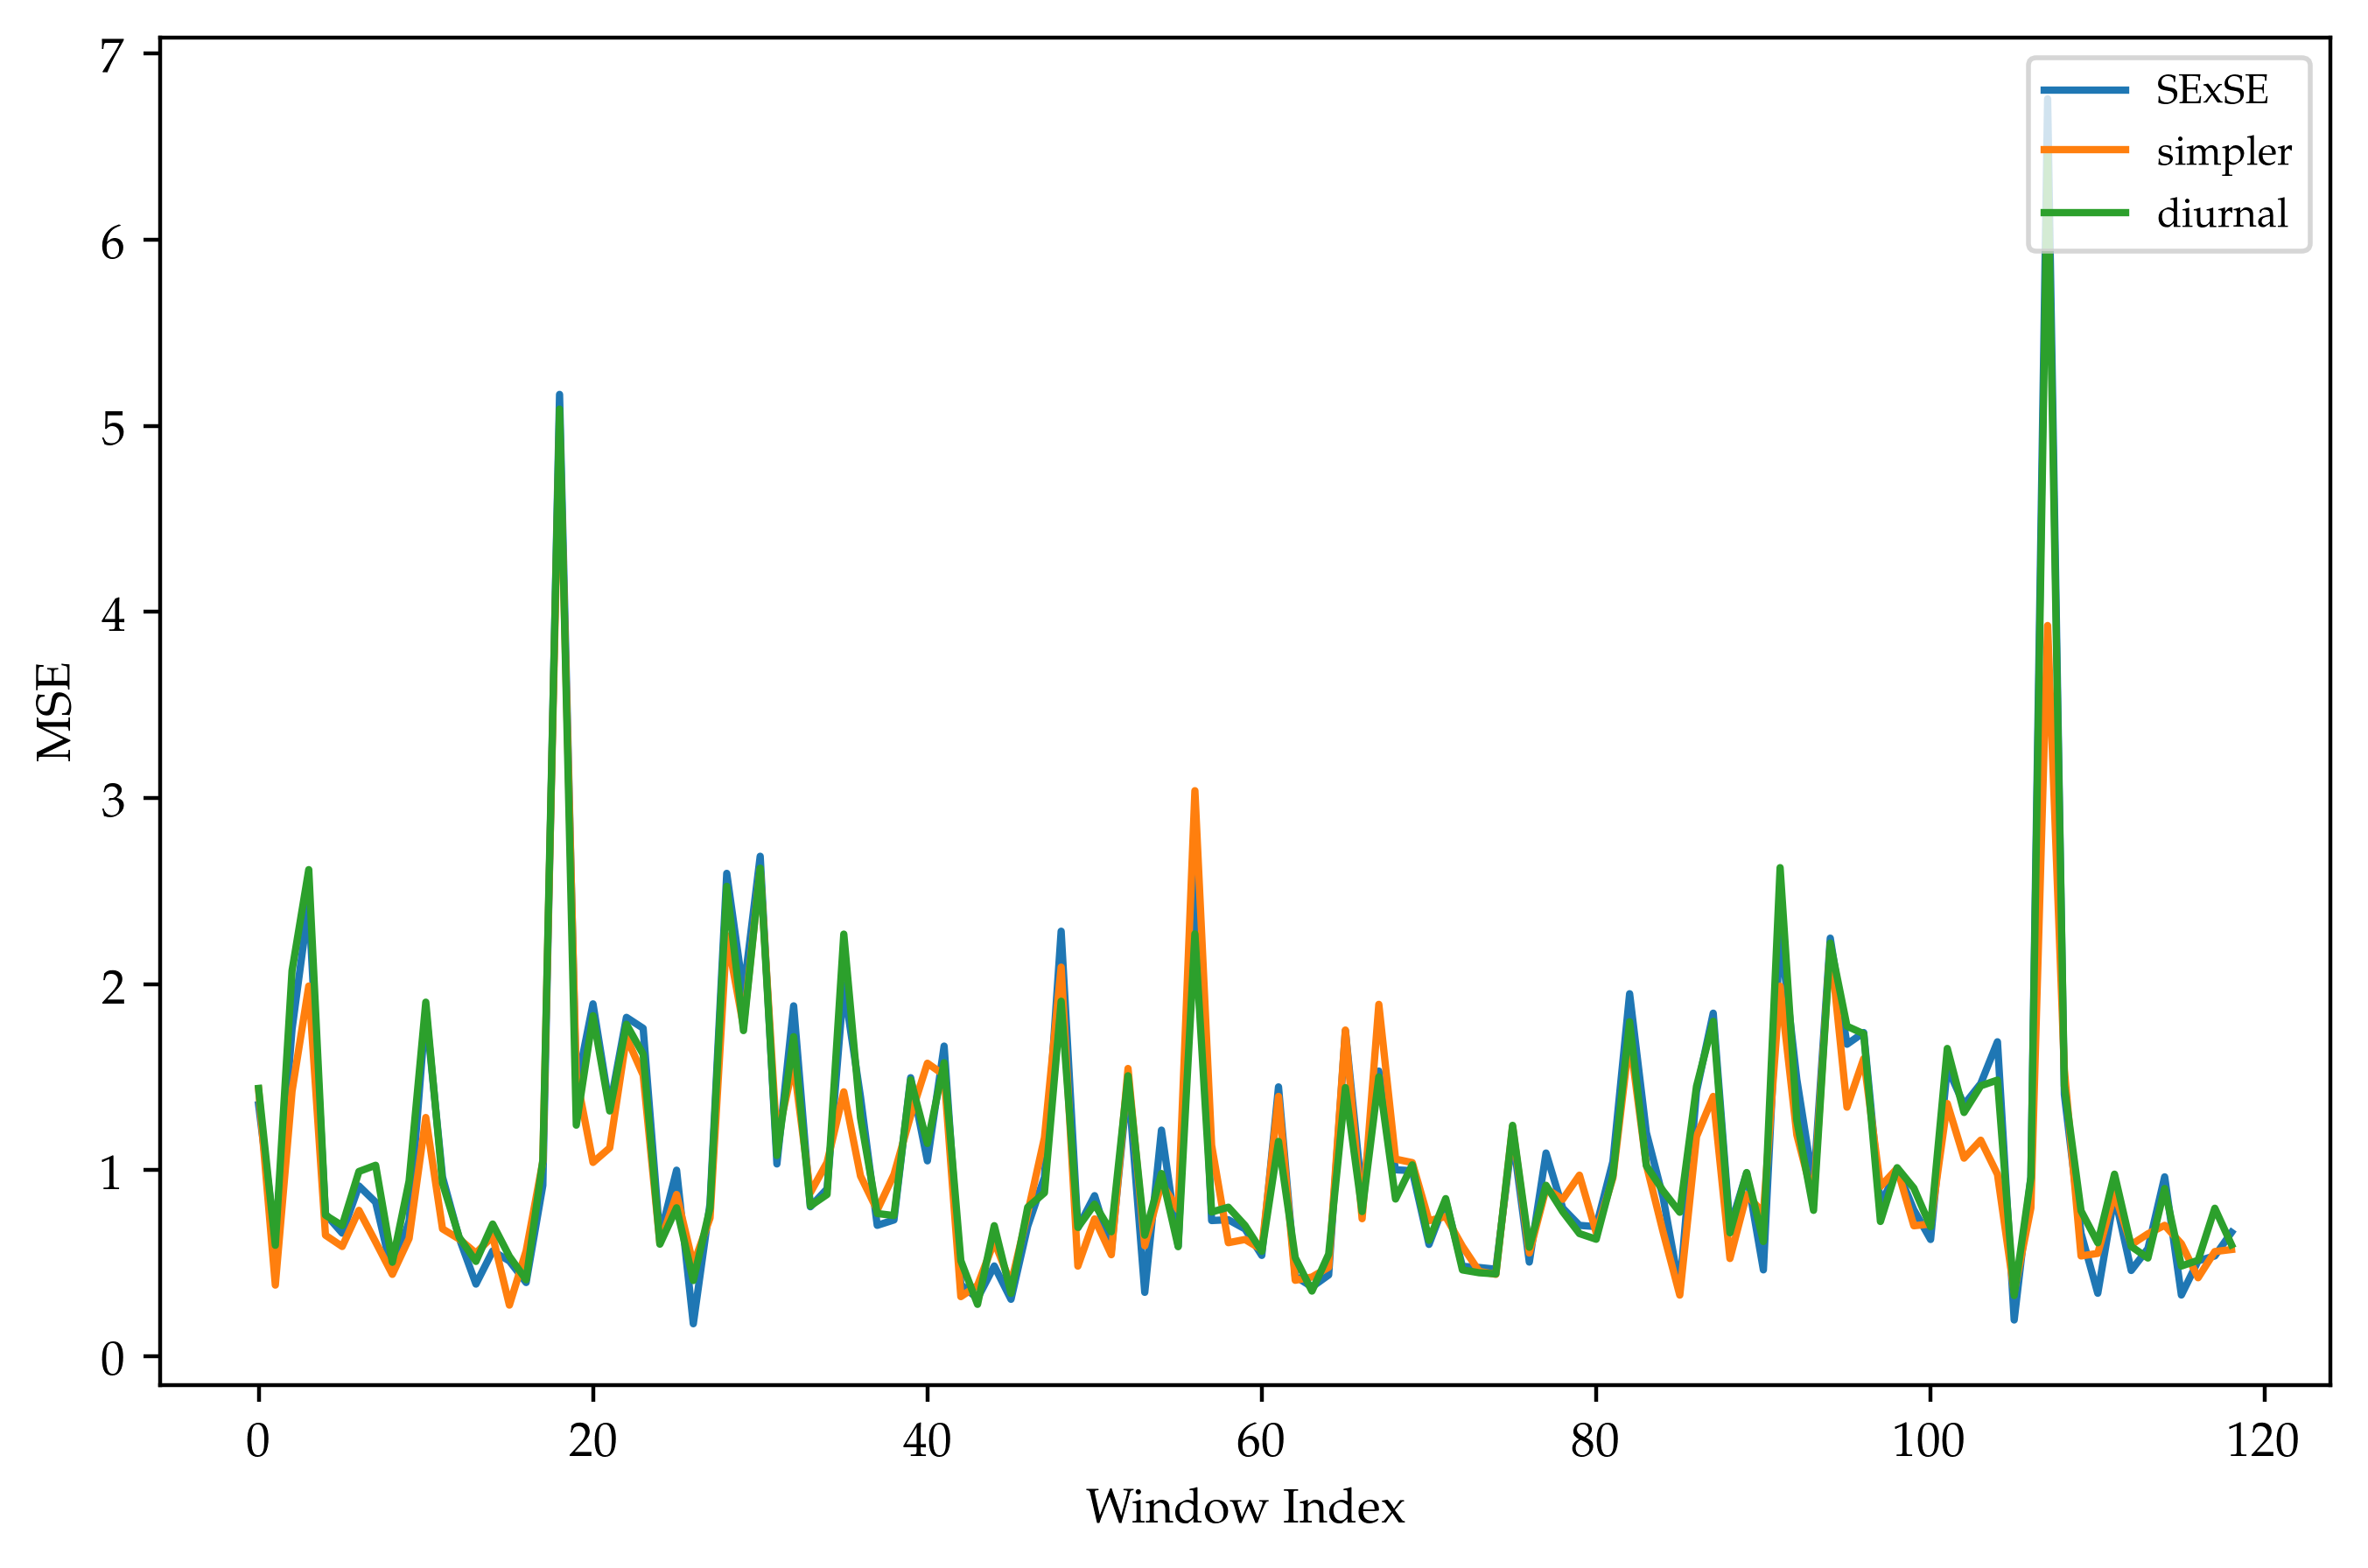

PyObject Text(0.5,94,'Window Index')

In [148]:
for GPmodel in ["SExSE", "simpler", "diurnal"]
    diagns = all_impt_diagn[GPmodel]
    plt.plot([Batch.mse(d) for d in diagns], label=GPmodel)
end
plt.legend(loc="upper right", fontsize="small")
plt.ylabel("MSE")
plt.xlabel("Window Index")

# Aggregating nearby-pred diagnostics

In [131]:
test_windows = [
    Batch.FittingWindow(Date(2015,1,1),Date(2015,3,14)),
    Batch.FittingWindow(Date(2015,1,25),Date(2015,4,8)),
    Batch.FittingWindow(Date(2015,2,18),Date(2015,5,2)),
    Batch.FittingWindow(Date(2015,3,14),Date(2015,5,26)),
    Batch.FittingWindow(Date(2015,4,8),Date(2015,6,20)),
    Batch.FittingWindow(Date(2015,5,2),Date(2015,7,14)),
    Batch.FittingWindow(Date(2015,5,26),Date(2015,8,7)),
    Batch.FittingWindow(Date(2015,6,20),Date(2015,9,1)),
    Batch.FittingWindow(Date(2015,7,14),Date(2015,9,25)),
    Batch.FittingWindow(Date(2015,8,7),Date(2015,10,19)),
    Batch.FittingWindow(Date(2015,9,1),Date(2015,11,13)),
    Batch.FittingWindow(Date(2015,9,25),Date(2015,12,7)),
    Batch.FittingWindow(Date(2015,10,19),Date(2015,12,31)),
]
;

In [132]:
test_ts = hourly_test[:ts];

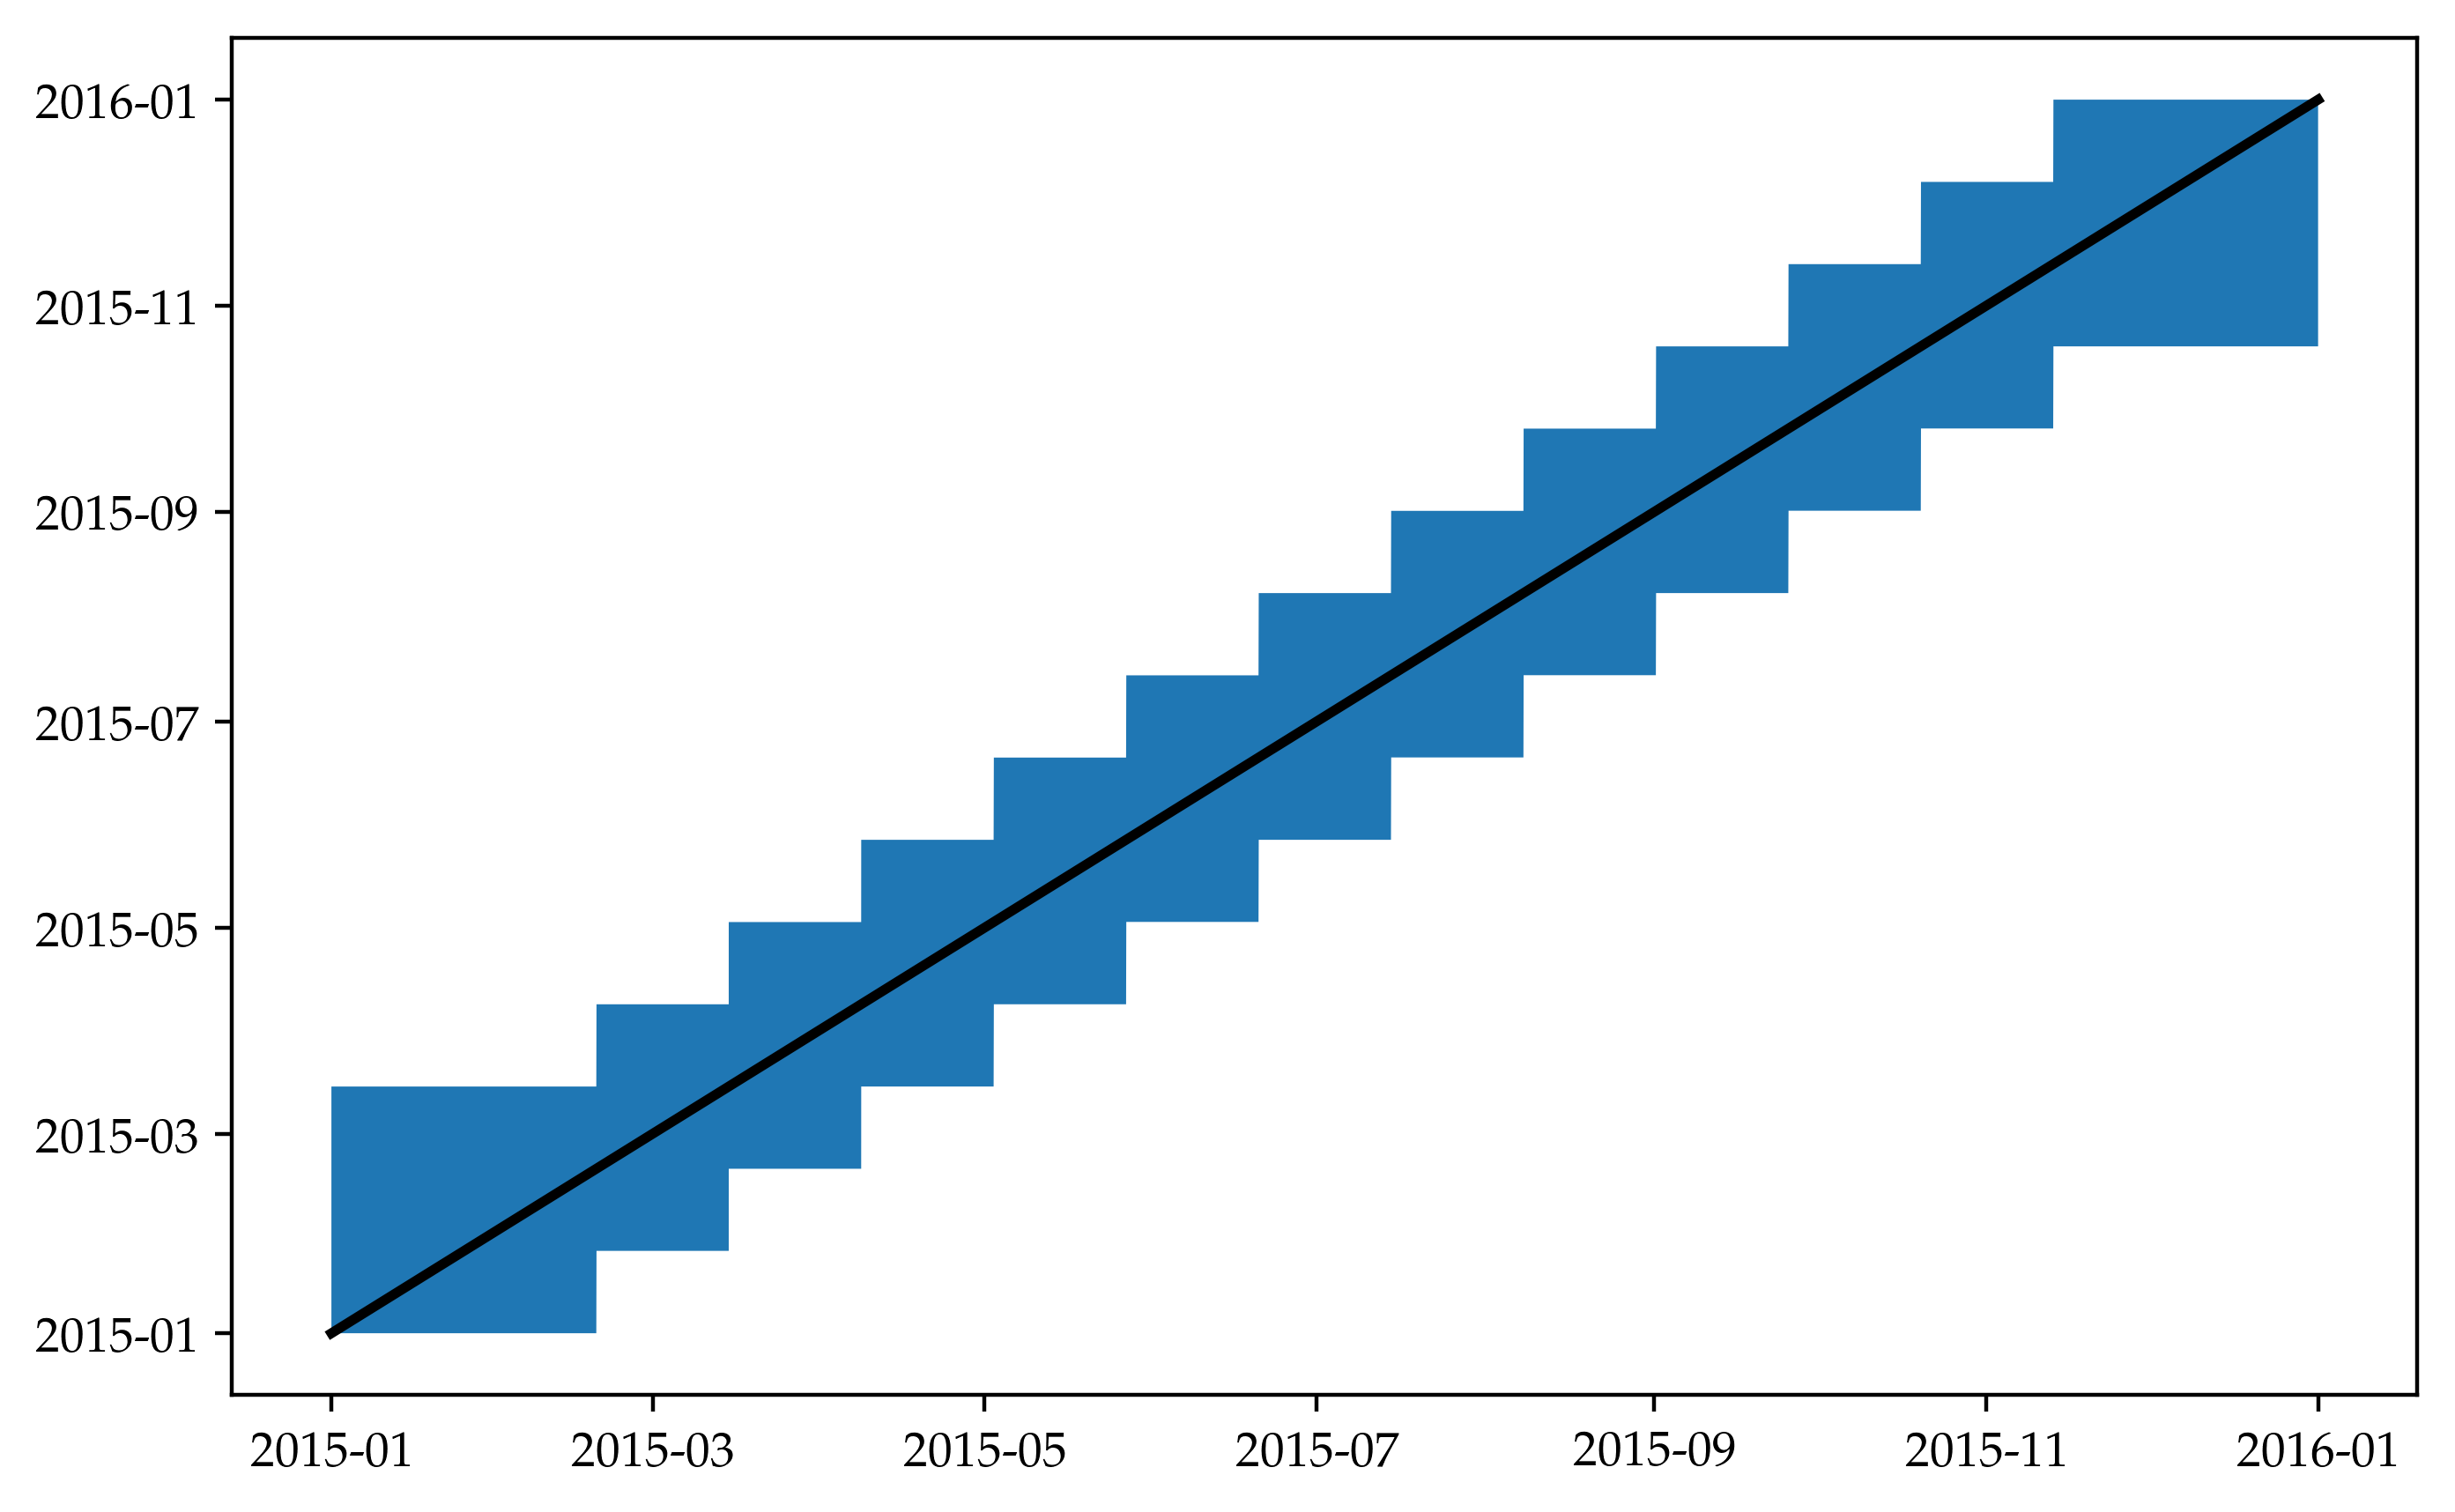

In [133]:
all_nearby_preds = TempModel.NearbyPrediction[]
for fw in test_windows
    push!(all_nearby_preds, Batch.get_nearby(fw, GPmodel, test_usaf))
end
window_times = [Batch.WindowTime(np.ts[1], np.ts[end]) for np in all_nearby_preds]
best_pred_window = [Batch.find_best_window(t, window_times) for t in test_ts]
plt.fill_between(test_ts, 
    [w.start_time for w in window_times[best_pred_window]],
    [w.end_time for w in window_times[best_pred_window]]
    )
plt.plot(test_ts, test_ts, color="black", linewidth=2)
;

In [134]:
all_nearby_diagn = Dict{String, Vector{Batch.NearbyPredDiagnostic}}()

Dict{String,Array{Batch.NearbyPredDiagnostic,1}} with 0 entries

In [135]:
function get_nearby_diagn(GPmodel)
    all_nearby_diagn[GPmodel] = Batch.NearbyPredDiagnostic[]
    all_nearby_preds = TempModel.NearbyPrediction[]
    for fw in test_windows
        push!(all_nearby_preds, Batch.get_nearby(fw, GPmodel, test_usaf))
    end
    window_times = [Batch.WindowTime(np.ts[1], np.ts[end]) for np in all_nearby_preds]
    best_pred_window = [Batch.find_best_window(t, window_times) for t in test_ts]
    for (ifw, fw) in enumerate(test_windows)
        fw_start, fw_end = extrema(t for (i,t) in enumerate(test_ts) if best_pred_window[i] == ifw)
        diagn = Batch.get_diagnostics(all_nearby_preds[ifw], test_trimmed, fw_start, fw_end; ndraws=1000)
        println("-----")
        push!(all_nearby_diagn[GPmodel], diagn)
    end
end

get_nearby_diagn (generic function with 1 method)

In [136]:
GPmodel="SExSE"
get_nearby_diagn(GPmodel)

-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----


In [137]:
GPmodel="diurnal"
get_nearby_diagn(GPmodel)

-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----


In [138]:
GPmodel="simpler"
get_nearby_diagn(GPmodel)

-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----


In [139]:
collect(keys(all_nearby_diagn))

3-element Array{String,1}:
 "SExSE"  
 "simpler"
 "diurnal"

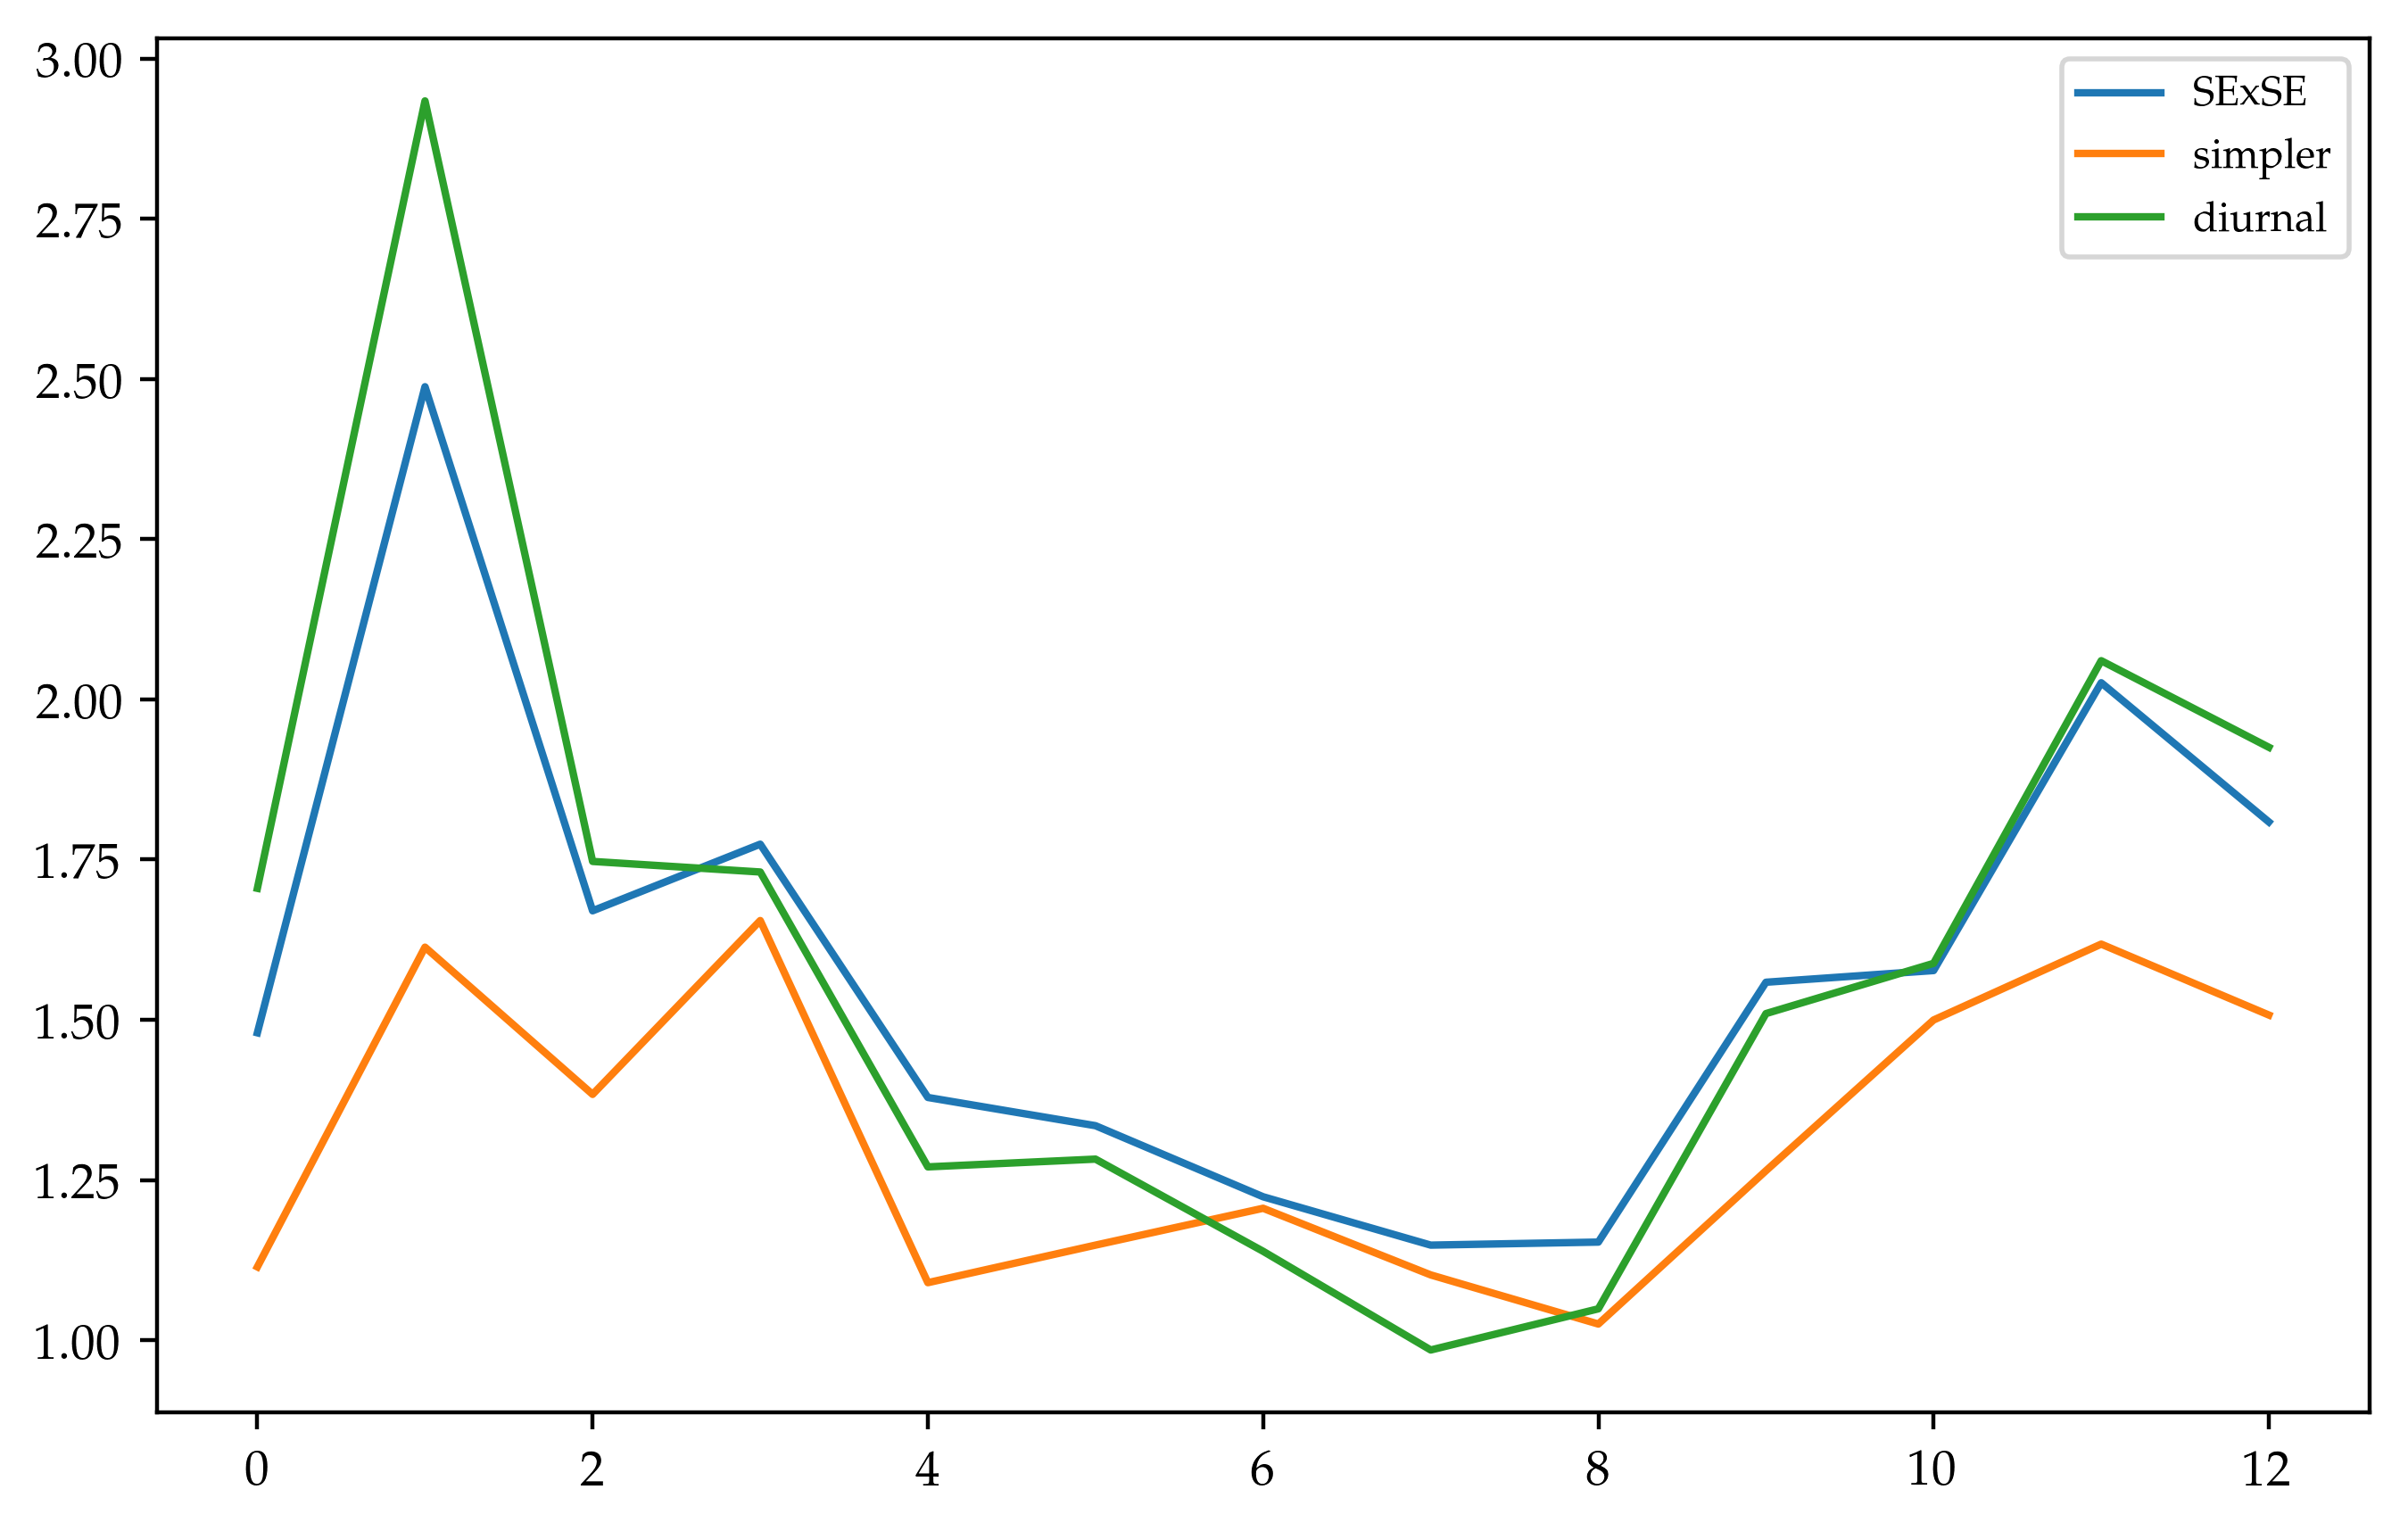

PyObject <matplotlib.legend.Legend object at 0x1437efeb8>

In [140]:
for GPmodel in keys(all_nearby_diagn)
    diagns = all_nearby_diagn[GPmodel]
    plt.plot([d.sumVarError/d.n for d in diagns], label=GPmodel)
end
plt.legend(loc="upper right", fontsize="small")

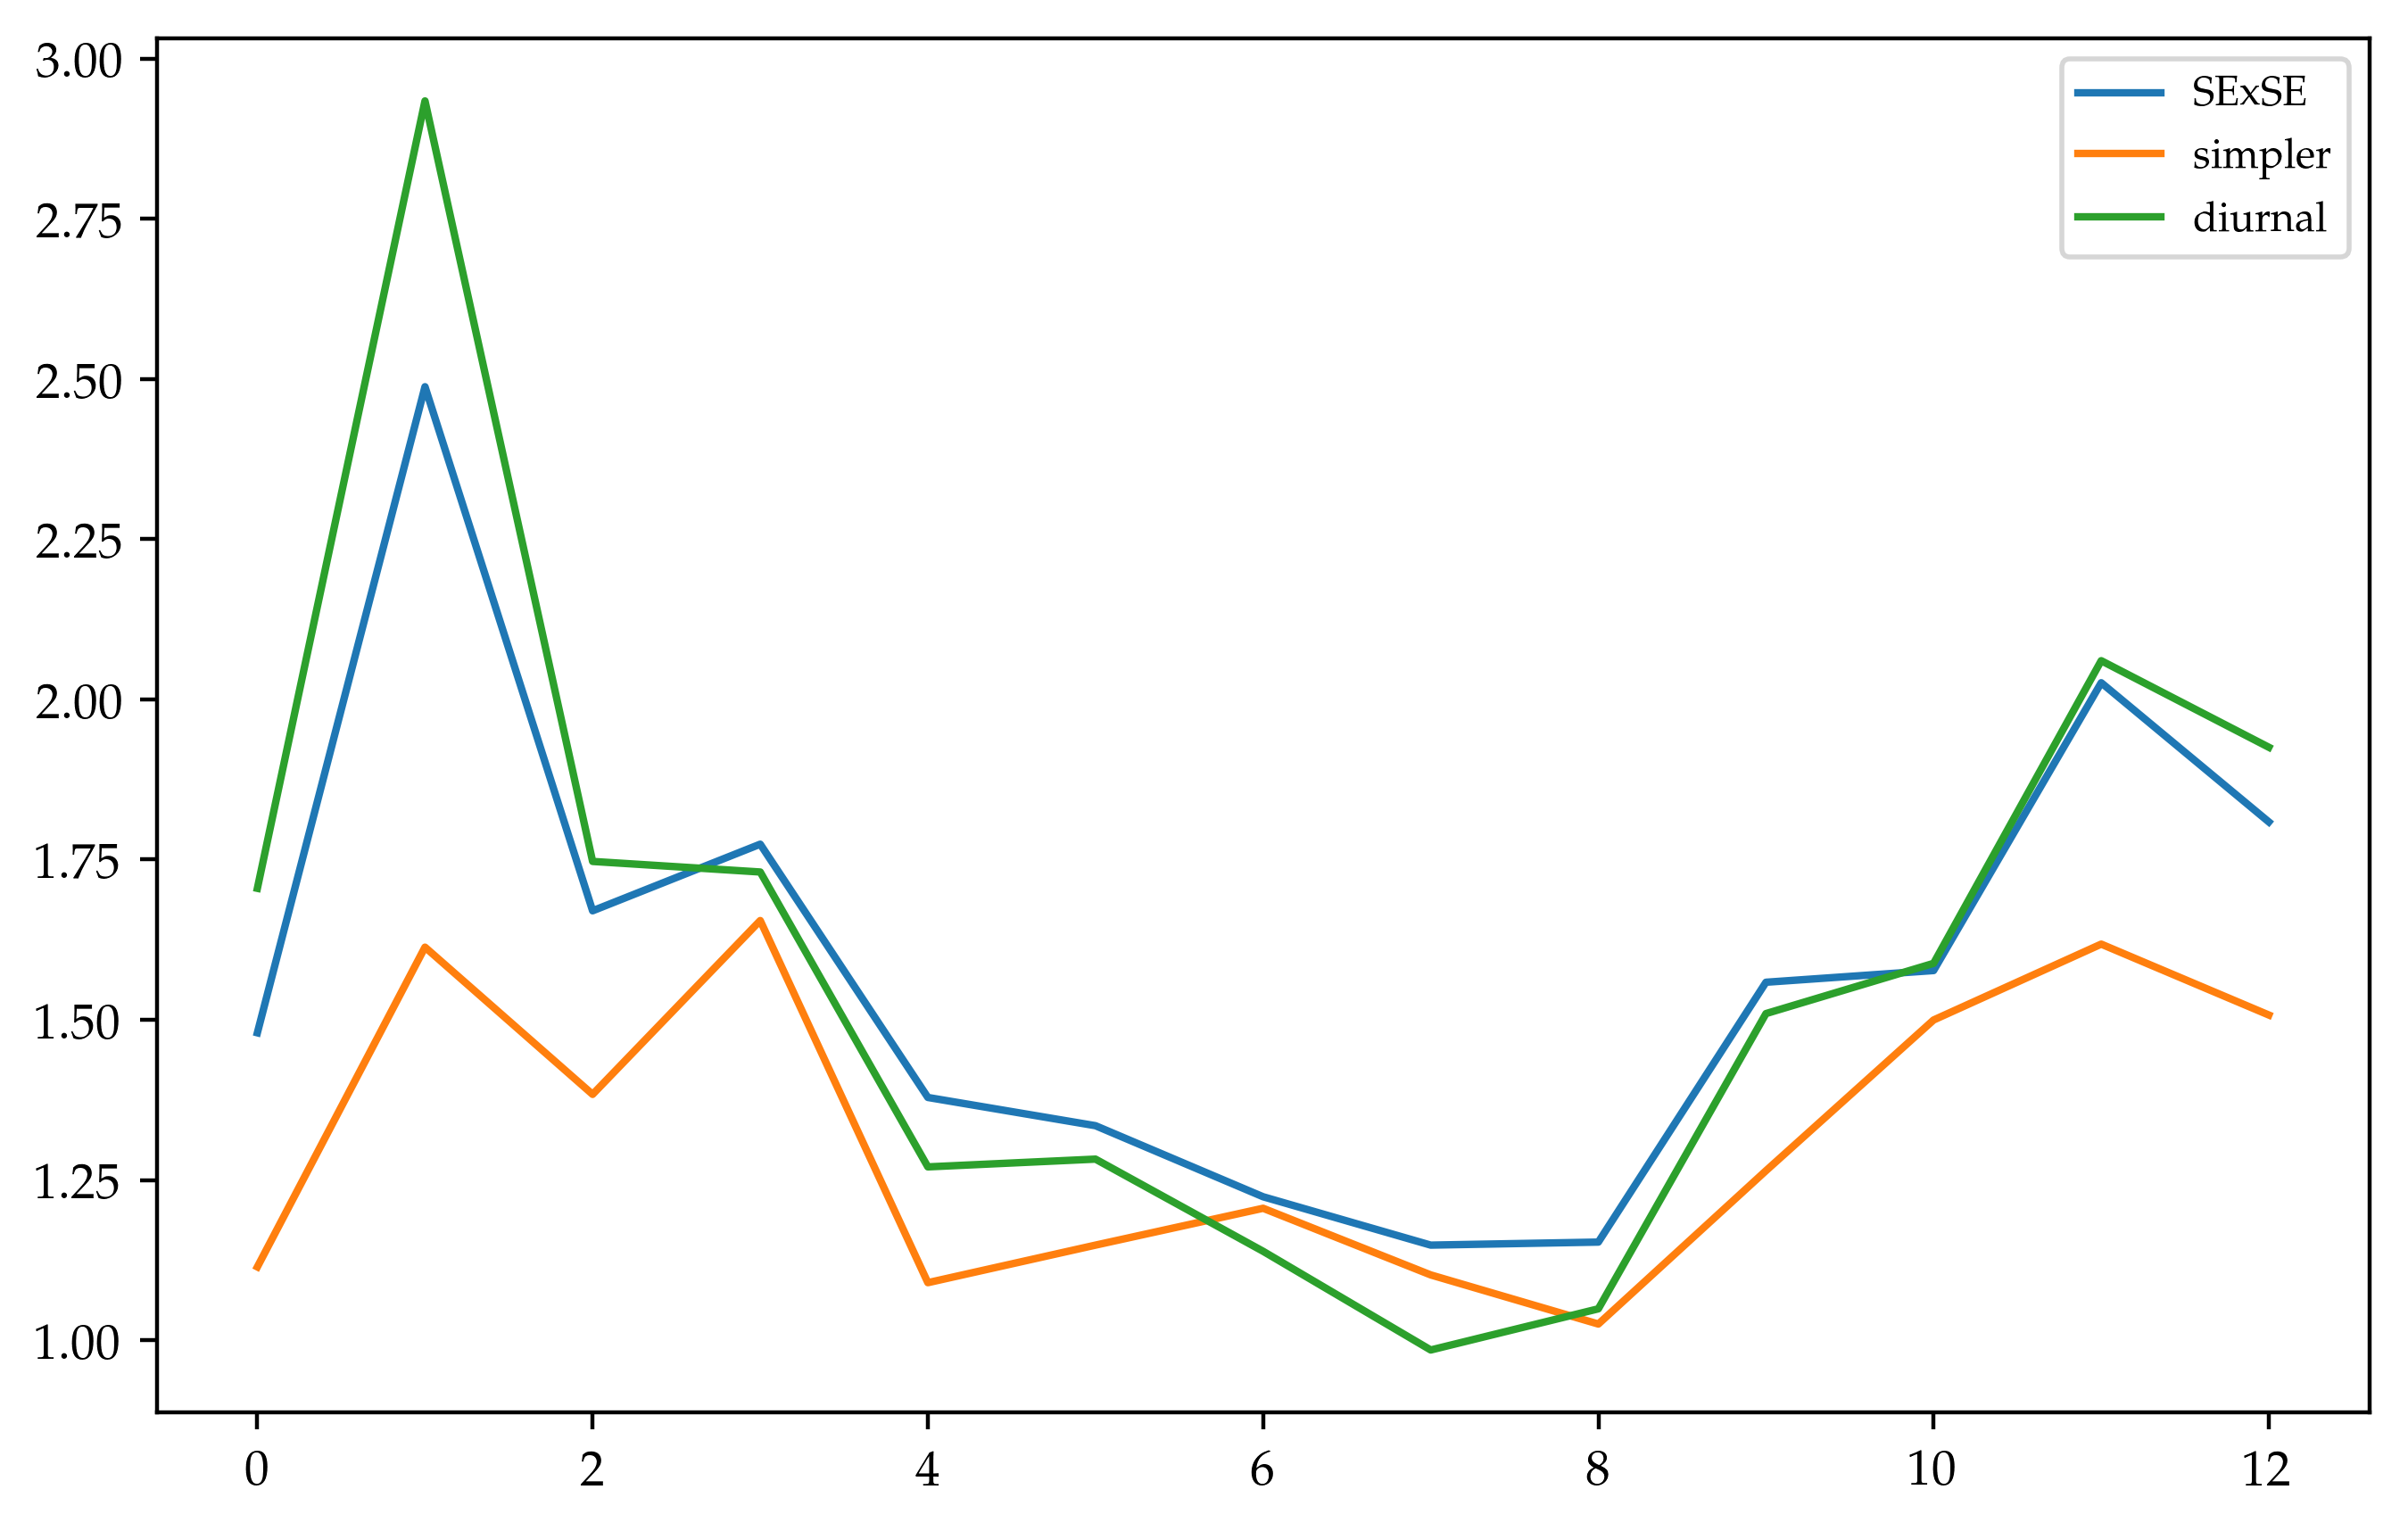

PyObject <matplotlib.legend.Legend object at 0x143238be0>

In [141]:
for GPmodel in keys(all_nearby_diagn)
    diagns = all_nearby_diagn[GPmodel]
    plt.plot([d.sumVarError/d.n for d in diagns], label=GPmodel)
end
plt.legend(loc="upper right", fontsize="small")

In [142]:
@assert sum(all_nearby_diagn["diurnal"]).n == nrow(hourly_test)

In [151]:
for GPmodel in ["SExSE", "diurnal", "simpler"]
    @printf("model: %s\n", GPmodel)
    diagns = all_nearby_diagn[GPmodel]
    sumdiag = sum(diagns)
    @printf("Empirical variance: %.3f\n", sumdiag.sumVarError/sumdiag.n)
    @printf("Estimated variance:  %.3f\n", sumdiag.sumEVarError/sumdiag.n)
    print("==========\n")
end

model: SExSE
Empirical variance: 1.589
Estimated variance:  0.875
model: diurnal
Empirical variance: 1.633
Estimated variance:  0.975
model: simpler
Empirical variance: 1.319
Estimated variance:  1.193
